<a href="https://colab.research.google.com/github/Chachabeat/Covid19/blob/master/DAA_2021_S2_Assignment_212604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose: using tweets to predict share price movements

# Question 3

## a. Text pre-processing

### i. Extract and Tokenise data

#### Import data

In [1]:
import pandas as pd
import numpy as np
import re

# Set-up access for files in Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# List contents in working folder
import os
os.listdir('gdrive/MyDrive/DAA Assignment')

['glove.6B.50d.txt',
 'DAA 2021 S2 Assignment - data SVW prices.csv',
 'DAA 2021 S2 Assignment - data tweets.csv',
 'tw_wordnet.pkl',
 'train_prep.pkl',
 'train_prep_GMT.pkl',
 'tweets_w_target_open.pkl',
 'tweets_w_KM_cluster.pkl',
 'Tweets_vs_Share_Price.json',
 '.ipynb_checkpoints',
 'logs',
 'tweets_w_response.pkl',
 'train_prep_PC_210921.pkl',
 'train_prep_TF_210921.pkl',
 'train_labels.pkl',
 'model.png']

In [3]:
# Switch directory to working folder for ease of access
os.chdir('gdrive/MyDrive/DAA Assignment')

In [4]:
# Import tweets data from google drive
df = pd.read_csv('DAA 2021 S2 Assignment - data tweets.csv', encoding='ISO-8859-1')

df.head() # have a look

,Unnamed: 0,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet
0,0,@Channel7,Channel 7,1.410000e+18,29/06/2021 4:00,The future of justice begins with her. â¡ï¸\...,4,0,212355,2177,22933,28871,613,16/01/2013 0:23,FALSE
1,1,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:49,RT @7NewsAustralia: Millions of Queenslanders ...,0,3,212355,2177,22933,28871,613,16/01/2013 0:23,7NewsAustralia
2,2,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:45,RT @BigBrotherAU: The Live Grand Final is here...,0,3,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU
3,3,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:10,RT @7olympics: Graham Arnold has high hopes fo...,0,1,212355,2177,22933,28871,613,16/01/2013 0:23,7olympics
4,4,@Channel7,Channel 7,1.410000e+18,29/06/2021 0:55,RT @BigBrotherAU: It's time for Australia to d...,0,4,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU


In [5]:
# Drop 1st column - irrelevant
df = df.drop('Unnamed: 0', axis=1)

#### Data checks

In [ ]:
# Check data types of features and any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147421 entries, 0 to 147420
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   username           147421 non-null  object        
 1   name               147421 non-null  object        
 2   tweet_id           147421 non-null  float64       
 3   tweet_post_time    147421 non-null  datetime64[ns]
 4   tweet_text         147421 non-null  object        
 5   tweet_likes        147421 non-null  int64         
 6   tweet_retweets     147421 non-null  int64         
 7   user_followers     147421 non-null  int64         
 8   user_friends       147421 non-null  int64         
 9   user_likes         147421 non-null  int64         
 10  user_tweets        147421 non-null  int64         
 11  user_public_lists  147421 non-null  int64         
 12  user_start_date    147421 non-null  object        
 13  retweet            147421 non-null  object  

In [247]:
# Check time period of tweets
df['tweet_post_time'] = pd.to_datetime(df.tweet_post_time, dayfirst=True) # convert string to date time

# Note: In UTC/GMT time
print(df.tweet_post_time.min())
print(df.tweet_post_time.max())

2009-09-30 00:45:00
2021-06-29 04:00:00


In [ ]:
# Check summary stats of numeric features - most features are very skewed 
# a small number of twitter accounts have the majority of likes, followers etc
df.describe()

,tweet_id,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists
count,1.474210e+05,147421.000000,1.474210e+05,147421.000000,147421.000000,147421.000000,147421.000000,147421.000000
mean,9.733679e+17,22.487549,2.732414e+02,109484.825059,1657.992009,4665.044308,34454.545872,376.277538
std,3.821711e+17,170.462748,1.456645e+04,140411.228857,4058.999980,5702.129722,64679.113311,567.051497
min,4.484851e+09,0.000000,0.000000e+00,64.000000,0.000000,0.000000,4.000000,0.000000
25%,6.870000e+17,0.000000,0.000000e+00,14877.000000,225.000000,618.000000,3234.000000,46.000000
50%,1.060000e+18,3.000000,2.000000e+00,62826.000000,571.000000,1643.000000,7771.000000,151.000000
75%,1.330000e+18,12.000000,5.000000e+00,164813.000000,1176.000000,7976.000000,31853.000000,380.000000
max,1.410000e+18,29766.000000,3.192070e+06,639595.000000,23285.000000,22933.000000,317563.000000,2765.000000


In [ ]:
# Check number of tweets per user
df.groupby('username').name.value_counts()

username         name                
@60Mins          60 Minutes Australia    3249
@7AFL            7AFL                    3248
@7Cricket        7Cricket                3248
@7NewsAustralia  7NEWS Australia         3251
@7horseracing    7HorseRacing ð       3247
                                         ... 
@sasaustralia    SAS Australia on 7       577
@sunriseon7      Sunrise                 3250
@thefrontbar7    The Front Bar           3248
@thelizhayes     Liz Hayes               3214
@tracygrimshaw   tracy grimshaw          3187
Name: name, Length: 62, dtype: int64

In [ ]:
# Check variability in lengths of tweets
df.tweet_text.apply(lambda text: len(text.split())).describe()

# Shortest tweet is 1 word, longest tweet is 87 words
# On average tweets are 16 words long

count    147421.000000
mean         16.491558
std           8.890002
min           1.000000
25%          10.000000
50%          16.000000
75%          22.000000
max          87.000000
Name: tweet_text, dtype: float64

In [37]:
# Check common words in tweets
from nltk import FreqDist
all_words = ' '.join(df['tweet_text'].tolist()) # join all rows into one list
freq_words = FreqDist(all_words.split(' ')) # split each word as separate items in a list
freq_words.most_common(15)

[('the', 77948),
 ('to', 49604),
 ('a', 42769),
 ('RT', 35461),
 ('of', 34345),
 ('and', 32778),
 ('on', 30101),
 ('in', 29079),
 ('for', 25859),
 ('is', 21447),
 ('you', 15888),
 ('with', 15217),
 ('at', 12079),
 ('The', 11371),
 ('', 11284)]

In [ ]:
# Define functions to look at common n-grams in tweets
from nltk.util import ngrams

def get_ngrams(tweet, grams):
  # If length of tweet is less than number of grams, skip tweet (returns None)
  if len(tweet) < grams:
    pass
  else:
    # Otherwise obtain list of ngrams in tweet
    return list(ngrams(tweet, grams))

def common_ngrams(tweets, grams, tokenise=True):
  # Tokenise tweets if not performed
  if tokenise:
    tweets = tweets.apply(lambda tweet: tweet.split())

  # Gets list of n-grams in each tweet
  ngram_tweets = tweets.apply(lambda tweet: get_ngrams(tweet, grams)).tolist() 

  # Appends list of n-grams into 1 big list
  ngram_all = []
  for ngram_tweet in ngram_tweets:
    if ngram_tweet is not None:
      ngram_all.extend(ngram_tweet)
  
  # Get frequency of n-grams in all tweets and return output
  freq_words = FreqDist(ngram_all)
  return freq_words

In [ ]:
# Most common bi-grams
bigrams = common_ngrams(df.tweet_text, grams=2)
bigrams.most_common(10)

[(('of', 'the'), 6705),
 (('in', 'the'), 6638),
 (('on', 'the'), 4755),
 (('for', 'the'), 4448),
 (('to', 'the'), 3733),
 (('at', 'the'), 2859),
 (('to', 'be'), 2782),
 (('for', 'a'), 2161),
 (('has', 'been'), 2087),
 (('will', 'be'), 1995)]

In [ ]:
# Most common tri-grams
trigrams = common_ngrams(df.tweet_text, grams=3)
trigrams.most_common(10)

[(('one', 'of', 'the'), 653),
 (('Australia,', 'the', 'chase'), 460),
 (('Tag', 'your', 'tweets'), 460),
 (('your', 'tweets', 'with'), 460),
 (('tweets', 'with', '#TheChaseAus.'), 460),
 (('the', 'chase', 'is'), 459),
 (('chase', 'is', 'ON!'), 457),
 (('ON!', 'Tag', 'your'), 457),
 (('as', 'the', 'chase'), 456),
 (('is', 'ON!', 'Tag'), 455)]

In [ ]:
# Most common quad-grams
quadgrams = common_ngrams(df.tweet_text, grams=4)
quadgrams.most_common(10)

[(('Tag', 'your', 'tweets', 'with'), 460),
 (('your', 'tweets', 'with', '#TheChaseAus.'), 460),
 (('Australia,', 'the', 'chase', 'is'), 458),
 (('ON!', 'Tag', 'your', 'tweets'), 457),
 (('the', 'chase', 'is', 'ON!'), 456),
 (('is', 'ON!', 'Tag', 'your'), 455),
 (('chase', 'is', 'ON!', 'Tag'), 454),
 (('as', 'the', 'chase', 'continues!'), 446),
 (('Not', 'near', 'a', 'TV?'), 442),
 (('tweets', 'with', '#TheChaseAus.', 'Not'), 397)]

In [ ]:
# Most common penta-grams
pentagrams = common_ngrams(df.tweet_text, grams=5)
pentagrams.most_common(10)

[(('Tag', 'your', 'tweets', 'with', '#TheChaseAus.'), 460),
 (('ON!', 'Tag', 'your', 'tweets', 'with'), 457),
 (('Australia,', 'the', 'chase', 'is', 'ON!'), 456),
 (('is', 'ON!', 'Tag', 'your', 'tweets'), 455),
 (('chase', 'is', 'ON!', 'Tag', 'your'), 454),
 (('the', 'chase', 'is', 'ON!', 'Tag'), 453),
 (('your', 'tweets', 'with', '#TheChaseAus.', 'Not'), 397),
 (('tweets', 'with', '#TheChaseAus.', 'Not', 'near'), 397),
 (('with', '#TheChaseAus.', 'Not', 'near', 'a'), 397),
 (('#TheChaseAus.', 'Not', 'near', 'a', 'TV?'), 397)]

In [ ]:
# There are some repeat tweets
df.loc[df.tweet_text.str.contains('Australia, the chase is ON')]

,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet
41384,@THECHASEAUS,The Chase Australia,9.360000e+17,30/11/2017 6:00,"Australia, the chase is ON! Tag your tweets wi...",1,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
41386,@THECHASEAUS,The Chase Australia,9.360000e+17,29/11/2017 6:00,"Australia, the chase is ON! Tag your tweets wi...",2,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
41388,@THECHASEAUS,The Chase Australia,9.350000e+17,28/11/2017 6:00,"Australia, the chase is ON! Tag your tweets wi...",0,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
41390,@THECHASEAUS,The Chase Australia,9.350000e+17,27/11/2017 6:00,"Australia, the chase is ON! Tag your tweets wi...",2,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
41393,@THECHASEAUS,The Chase Australia,9.340000e+17,23/11/2017 6:00,"Australia, the chase is ON! Tag your tweets wi...",1,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43266,@THECHASEAUS,The Chase Australia,6.460000e+17,21/09/2015 7:00,"Australia, the chase is ON! Tag your tweets wi...",1,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
43276,@THECHASEAUS,The Chase Australia,6.450000e+17,18/09/2015 7:00,"Australia, the chase is ON! Tag your tweets wi...",2,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE
43282,@THECHASEAUS,The Chase Australia,6.440000e+17,17/09/2015 7:00,"Australia, the chase is ON! Tag your tweets wi...",4,2,1566,0,310,2056,8,11/08/2015 0:16,FALSE
43295,@THECHASEAUS,The Chase Australia,6.440000e+17,16/09/2015 7:00,"Australia, the chase is ON! Tag your tweets wi...",1,1,1566,0,310,2056,8,11/08/2015 0:16,FALSE


At face value, some of these tweets do not seem to have a strong influence on share prices, for example, promotion of TV shows. However, from our Domain Knowledge research, we gathered that the main source of revenue for TV networks is through advertising during shows. Hence, it is possible that a show with higher promotion and online activity may draw greater viewers and positively impact the network's share price.

#### Tokenise tweet text

Raw text cannot be understood by a computer or machine learning algorithms. Hence, the text needs to be converted to a series of numbers, or vectors, and the first step is to tokenise the text by splitting up whole tweets into lists of individual tokens. This lets us use vectorisation techniques on individual tokens as opposed to entire sentences.

We will consider two methods of tokenisation:
1. 'Simple' tokenisation - splitting a sentence into tokens on white space.
2. NLTK's word tokenizer - splits on white space and punctuation.

In [ ]:
# Simple tokenisation - split by white space
tw_tokens_simple = df['tweet_text'].apply(lambda x: x.split())

# Store lengths of tokenised output
token_len1 = [len(tokens) for tokens in tw_tokens_simple]

In [ ]:
# Download resource for tokenising
import nltk
nltk.download('punkt') 

# Use tokenizer from nltk - splits out punctuation as their own tokens
from nltk import word_tokenize

tw_tokens = df['tweet_text'].apply(word_tokenize)

# Store lengths of tokenised output
token_len2 = [len(tokens) for tokens in tw_tokens]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


KeyboardInterrupt: ignored

In [ ]:
# Compare tokenisation results for a couple of cases
print(tw_tokens_simple[0])
print(tw_tokens[0])

['The', 'future', 'of', 'justice', 'begins', 'with', 'her.', 'â\x9a¡ï¸\x8f', '#WonderWoman', 'Tonight', '8.30', 'https://t.co/1toX55fvQ4']
['The', 'future', 'of', 'justice', 'begins', 'with', 'her', '.', 'â\x9a¡ï¸\x8f', '#', 'WonderWoman', 'Tonight', '8.30', 'https', ':', '//t.co/1toX55fvQ4']


In [ ]:
print(tw_tokens_simple[10])
print(tw_tokens[10])

['RT', '@BigBrotherAU:', 'The', 'final', 'three', 'is', 'set,', 'now', "it's", 'over', 'to', 'you', 'Australia!', 'Head', 'to', 'https://t.co/smgYzcscZt', 'to', 'choose', 'your', 'winner!', 'ð\x9f\x8e\x89ð\x9f\x91\x91', '#BBAU', 'hâ\x80¦']
['RT', '@', 'BigBrotherAU', ':', 'The', 'final', 'three', 'is', 'set', ',', 'now', 'it', "'s", 'over', 'to', 'you', 'Australia', '!', 'Head', 'to', 'https', ':', '//t.co/smgYzcscZt', 'to', 'choose', 'your', 'winner', '!', 'ð\x9f\x8e\x89ð\x9f\x91\x91', '#', 'BBAU', 'hâ\x80¦']


In [ ]:
# Compare max lengths
print(max(token_len1))
print(max(token_len2))

87
91


NLTK's `word_tokenize` also tokenises punctuation such as '@' as individual tokens. Certain punctuation appears useful, such as, '@' to identify user mentions and '://' for URLs. Hence, we will use the simple tokenisation on white space with `split`. 

In [ ]:
# Check the number of total unique tokens in our raw text data before cleaning
all_tokens = []

for tweet in tw_tokens_simple:
  all_tokens.extend(tweet)

print('Total tokens: {:,}\nTotal unique tokens: {:,}'.format(len(all_tokens), len(set(all_tokens))))

Total tokens: 2,431,202
Total unique tokens: 297,737


### ii. Data Cleaning

In [ ]:
# Import stopwords list from nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Check frequency of stop words in tweet data - most of them appear quite frequently
stopword_freq = {word: freq_words[word] for word in stop_words}
stopword_freq

{'a': 42769,
 'about': 4782,
 'above': 94,
 'after': 4999,
 'again': 741,
 'against': 896,
 'ain': 0,
 'all': 5899,
 'am': 584,
 'an': 5769,
 'and': 32778,
 'any': 898,
 'are': 9756,
 'aren': 0,
 "aren't": 140,
 'as': 6496,
 'at': 12079,
 'be': 9608,
 'because': 590,
 'been': 5297,
 'before': 1300,
 'being': 1845,
 'below': 97,
 'between': 687,
 'both': 525,
 'but': 4813,
 'by': 4751,
 'can': 3226,
 'couldn': 0,
 "couldn't": 267,
 'd': 4,
 'did': 1108,
 'didn': 0,
 "didn't": 526,
 'do': 2869,
 'does': 609,
 'doesn': 0,
 "doesn't": 433,
 'doing': 686,
 'don': 5,
 "don't": 1207,
 'down': 1584,
 'during': 783,
 'each': 404,
 'few': 725,
 'for': 25859,
 'from': 8799,
 'further': 167,
 'had': 2095,
 'hadn': 0,
 "hadn't": 19,
 'has': 10949,
 'hasn': 0,
 "hasn't": 106,
 'have': 9027,
 'haven': 3,
 "haven't": 163,
 'having': 723,
 'he': 3756,
 'her': 4382,
 'here': 1192,
 'hers': 1,
 'herself': 74,
 'him': 1223,
 'himself': 174,
 'his': 6750,
 'how': 2474,
 'i': 211,
 'if': 2063,
 'in': 29079,

In [ ]:
# Compare with most frequent words - looks like a lot of overlap with NLTK's stopwords
freq_words.most_common(30)

[('the', 77948),
 ('to', 49604),
 ('a', 42769),
 ('RT', 35461),
 ('of', 34345),
 ('and', 32778),
 ('on', 30101),
 ('in', 29079),
 ('for', 25859),
 ('is', 21447),
 ('you', 15888),
 ('with', 15217),
 ('at', 12079),
 ('The', 11371),
 ('', 11284),
 ('I', 11053),
 ('has', 10949),
 ('this', 10757),
 ('are', 9756),
 ('be', 9608),
 ('have', 9027),
 ('from', 8799),
 ('it', 8781),
 ('your', 7535),
 ('that', 7345),
 ('was', 7285),
 ('will', 7213),
 ('his', 6750),
 ('-', 6529),
 ('as', 6496)]

In [ ]:
# Check which words aren't in NLTK's stop words
[word for word, _ in freq_words.most_common(30) if word not in stop_words]

['RT', 'The', '', 'I', '-']

The stopwords from NLTK's corpus are made up of words that generally do not add semantic meaning in text, such as 'I' and 'am', and should be removed.  

Looking at the most frequent words in our tweet data, most of these words are stop words in NLTK's list, which is to be expected as stop words are occur frequently across texts. The token 'RT' which indicates a 'retweet' or reply to a user, also occurs very frequently. As it is unlikely to add much meaning, we will add 'RT' to the list of stopwords.

The semantic value of usernames in retweets and URL's is also likely low. In particular, retweets are already captured as a feature, hence, the text of the retweeted username will also be removed. Hashtags may add meaning, particularly if multiple users use them, so these will be kept and inspected later.

In [ ]:
# Add 'rt' to list of stop words
stop_words.append('rt')

In [204]:
# Use simple tokenisation on white space, to capture user mentions and URLs easily
tw_tokens_simple = df['tweet_text'].apply(lambda x: x.split())

In [ ]:
# Remove user mentions
tw_tokens_clean = tw_tokens_simple.apply(lambda text: [token for token in text if not re.match('@', token)])
print(tw_tokens_simple[16])
print(tw_tokens_clean[16])

['RT', '@BigBrotherAU:', 'Who', 'will', 'make', 'it', 'through', 'to', 'the', '#BBAU', 'Live', 'Grand', 'Final?', 'Find', 'out', 'tonight', '7.30', 'on', '@Channel7', 'https://t.co/N5JNSBwOWY']
['RT', 'Who', 'will', 'make', 'it', 'through', 'to', 'the', '#BBAU', 'Live', 'Grand', 'Final?', 'Find', 'out', 'tonight', '7.30', 'on', 'https://t.co/N5JNSBwOWY']


In [ ]:
# Remove URLs
tw_tokens_clean = tw_tokens_clean.apply(lambda text: [token for token in text if not re.match('http', token)])
print(tw_tokens_clean[16])

['RT', 'Who', 'will', 'make', 'it', 'through', 'to', 'the', '#BBAU', 'Live', 'Grand', 'Final?', 'Find', 'out', 'tonight', '7.30', 'on']


In [ ]:
# Turn tokens into lower-case and remove stop words
tw_tokens_clean = tw_tokens_clean.apply(lambda text: [token.lower() for token in text if token.lower() not in stop_words])
print(tw_tokens_clean[16])

['make', '#bbau', 'live', 'grand', 'final?', 'find', 'tonight', '7.30']


There are still punctuation, emojis and time as tokens. Time will be removed as the tweets have a *tweet_post_time* feature. Emojis are difficult to interpret so will also be removed. Remaining punctuation such as '#' will be removed too, as the remaining words should carry most of the meaning. 

In [ ]:
# Remove any non-letter characters and words that have no letters
tw_tokens_clean = tw_tokens_clean.apply(lambda text: [re.sub('[^a-z]', '', word) for word in text])
tw_tokens_clean = tw_tokens_clean.apply(lambda text: [word for word in text if len(word) > 0])
print(tw_tokens_clean[16])

['make', 'bbau', 'live', 'grand', 'final', 'find', 'tonight']


In [ ]:
# Check most frequent words after cleaning
all_words = ' '.join(tw_tokens_clean.apply(lambda x: ' '.join(x)).tolist()) # join all rows into one list
freq_words_clean = FreqDist(all_words.split())
freq_words_clean.most_common(30)

[('tonight', 8787),
 ('news', 7776),
 ('pm', 7030),
 ('today', 6883),
 ('new', 6482),
 ('one', 5806),
 ('time', 4836),
 ('get', 4652),
 ('amp', 4382),
 ('us', 4263),
 ('back', 4249),
 ('mins', 4139),
 ('great', 3997),
 ('day', 3972),
 ('love', 3922),
 ('see', 3756),
 ('like', 3733),
 ('first', 3680),
 ('thevoiceau', 3597),
 ('mafs', 3552),
 ('go', 3545),
 ('good', 3540),
 ('night', 3385),
 ('australia', 3373),
 ('thanks', 3360),
 ('last', 3319),
 ('theblock', 3303),
 ('watch', 3185),
 ('aca', 3129),
 ('nrl', 3062)]

Some words look interesting - 'amp' and 'mafs' - as they do not make much sense at initial glance. We will check a few original tweets containing these words.

In [ ]:
# It looks like 'amp' is a result of '&' being parsed as '&amp;'
# We will remove amp as a stopword
for i in df.loc[df['tweet_text'].str.contains('amp'), 'tweet_text'].sample(5):
  print(i)

RT @wwos: ð¦ðºð¥ @chrisoconnelll is a champion player and a champion bloke! ð¥ð¦ðº

WATCH: @Channel9 
STREAM: https://t.co/TYsz5RZN3Z 

#9WWOS #Aâ¦


RT @catecamp: Excited to have collected our Olympic gear! Wearing the green and gold is an honour that never diminishes over time. https://â¦


RT @ScreenAustralia: .@DressmakerMovie, Last Cab to Darwin, @MadMaxMovie, @HTMmovie, Cut Snake, Paper Planes &amp; @TannaMovie nominated for @Fâ¦


Reaso &amp; I.
Post-show....... Relaxing in wardrobe.
Is it Friday yet? ð @ Martin Place https://t.co/vj4bfItcNG


Hear hear. Fine dining restaurants running produce stalls and takeaway. Pilots working at supermarkets. Many examples of innovation and determination. Humbling lessons in human resilience to be taken from this.  Respect. https://t.co/C1QyfYXo5g




In [ ]:
# 'mafs' is from the hashtag for the show Married at First Sight
# We will keep mafs
for i in df.loc[df['tweet_text'].str.contains('mafs'), 'tweet_text'].sample(5):
  print(i)

RT @nasbomb_: #mafs time! https://t.co/RNedphShsO
RT @bbbeckb: When you connect the dots and realise itâs Lizzie #mafsau  #MAFS https://t.co/0W3wcAizgO
RT @ThePurityOfEvil: I love you, Mickâs dad. #mafs #mafsAU
RT @Ben_Shute: Turning over to #mafs.. https://t.co/0tG4w7ffoA
RT @Ben_Shute: My name is Jason and... #mafs https://t.co/GHNIvWoysf


In [ ]:
# We will do another round of stop word removal - with 'amp' being added
stop_words.append('amp')

tw_tokens_clean = tw_tokens_clean.apply(lambda text: [word for word in text if word not in stop_words])

In [ ]:
# Check most frequent words after cleaning
all_words = ' '.join(tw_tokens_clean.apply(lambda x: ' '.join(x)).tolist()) # join all rows into one list
freq_words_clean = FreqDist(all_words.split())
freq_words_clean.most_common(30)

[('tonight', 8787),
 ('news', 7776),
 ('pm', 7030),
 ('today', 6883),
 ('new', 6482),
 ('one', 5806),
 ('time', 4836),
 ('get', 4652),
 ('us', 4263),
 ('back', 4249),
 ('mins', 4139),
 ('great', 3997),
 ('day', 3972),
 ('love', 3922),
 ('see', 3756),
 ('like', 3733),
 ('first', 3680),
 ('thevoiceau', 3597),
 ('mafs', 3552),
 ('go', 3545),
 ('good', 3540),
 ('night', 3385),
 ('australia', 3373),
 ('thanks', 3360),
 ('last', 3319),
 ('theblock', 3303),
 ('watch', 3185),
 ('aca', 3129),
 ('nrl', 3062),
 ('im', 3011)]

'Amp' was removed successfully. Some words such as 'get' and 'like', appear like they could be stopwords but we also want to avoid stripping out too many words at the beginning, so we will leave them in for now. 

We will do a few more checks on the length of tweets after cleaning and common n-grams.

In [ ]:
# Check length of tokens - some tweets have been reduced to no words left
import numpy as np

token_len = [len(tokens) for tokens in tw_tokens_clean]
print('Average tweet length: {:.3g}\nShortest: {} Longest: {}'.format(np.mean(token_len), min(token_len), max(token_len)))

Average tweet length: 8.53
Shortest: 0 Longest: 48


In [ ]:
# Look at longest cleaned tweet 
import numpy as np
print(tw_tokens_clean[np.array(token_len).argmax()])

['big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'dance', 'big', 'danc']


In [ ]:
# Check common bi-grams after cleaning
bigrams_clean = common_ngrams(tw_tokens_clean, 2, tokenise=False)
bigrams_clean.most_common(10)

[(('tonight', 'pm'), 2111),
 (('wwos', 'nrl'), 1824),
 (('last', 'night'), 817),
 (('grand', 'final'), 810),
 (('cant', 'wait'), 787),
 (('homeandaway', 'summerbay'), 682),
 (('prime', 'minister'), 663),
 (('well', 'done'), 586),
 (('thanks', 'watching'), 547),
 (('sunday', 'pm'), 537)]

In [ ]:
# Compare with bi-grams before cleaning - the volume of common bi-grams has reduced significantly
bigrams.most_common(10)

NameError: ignored

In [ ]:
# The volume of common tri-grams has not changed too much
trigrams_clean = common_ngrams(tw_tokens_clean, 3, tokenise=False)
trigrams_clean.most_common(10)

[(('tag', 'tweets', 'thechaseaus'), 460),
 (('chase', 'tag', 'tweets'), 458),
 (('australia', 'chase', 'tag'), 456),
 (('tweets', 'thechaseaus', 'near'), 397),
 (('thechaseaus', 'near', 'tv'), 397),
 (('near', 'tv', 'follow'), 397),
 (('tv', 'follow', 'livestream'), 397),
 (('tune', 'next', 'time'), 352),
 (('next', 'time', 'chase'), 352),
 (('time', 'chase', 'continues'), 352)]

In [ ]:
trigrams.most_common(10)

[(('one', 'of', 'the'), 653),
 (('Australia,', 'the', 'chase'), 460),
 (('Tag', 'your', 'tweets'), 460),
 (('your', 'tweets', 'with'), 460),
 (('tweets', 'with', '#TheChaseAus.'), 460),
 (('the', 'chase', 'is'), 459),
 (('chase', 'is', 'ON!'), 457),
 (('ON!', 'Tag', 'your'), 457),
 (('as', 'the', 'chase'), 456),
 (('is', 'ON!', 'Tag'), 455)]

In [ ]:
### From data cleaning, Total tokens has reduced by 50% and the total unique tokens has reduced by 75%
print('Before Cleaning:\nTotal tokens: {:,}\nTotal unique tokens: {:,}\n'.\
      format(len(all_tokens), len(set(all_tokens))))

all_tokens = []

for tweet in tw_tokens_clean:
  all_tokens.extend(tweet)

print('After Cleaning:\nTotal tokens: {:,}\nTotal unique tokens: {:,}'.\
      format(len(all_tokens), len(set(all_tokens))))

Before Cleaning:
Total tokens: 2,431,202
Total unique tokens: 297,737
After Cleaning:
Total tokens: 1,257,116
Total unique tokens: 69,149


### iii. Stemming / lemmatisation

To reduce variability in spelling or grammer across tokens, we will look into stemming and/or lemmatising our tokens. Stemming refers to the process of reducing a word to its 'root' word by dropping any suffixes or plurals. For example, 'trees' can be stemmed to 'tree'. However, stemming only looks at how the word appears and does not account for its lexical meaning. 

Lemmatisation is the process of reducing a word to its 'lemma', which is like the root word that can be found in a dictionary. It is typically a more powerful process as it can convert words like 'babies' to 'baby'. 

Stemming and lemmatisation will reduce the number of unique words in our text, which also reduces the dimension of word features we have for modelling. 

We will first try stemming our words by comparing stemming results from NLTK's `stem` module.

In [ ]:
# Import stemming functions from NLTK
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

porter = PorterStemmer() # PorterStemmer is known for its simplicity and speed
lancaster = LancasterStemmer() # LancasterStemmer is simple but can over-stem, reducing linguistic meaning

tw_porter = tw_tokens_clean.apply(lambda text: [porter.stem(word) for word in text])
tw_lanc = tw_tokens_clean.apply(lambda text: [lancaster.stem(word) for word in text])

In [ ]:
# Compare stemming results to original
print(tw_tokens_clean[16])
print(tw_porter[16])
print(tw_lanc[16])

['make', 'bbau', 'live', 'grand', 'final', 'find', 'tonight']
['make', 'bbau', 'live', 'grand', 'final', 'find', 'tonight']
['mak', 'bbau', 'liv', 'grand', 'fin', 'find', 'tonight']


In [ ]:
# Look at a few more results
print(tw_tokens_clean[0])
print(tw_porter[0])
print(tw_lanc[0])

['future', 'justice', 'begins', 'wonderwoman', 'tonight']
['futur', 'justic', 'begin', 'wonderwoman', 'tonight']
['fut', 'just', 'begin', 'wonderwom', 'tonight']


In [ ]:
print(tw_tokens_clean[1])
print(tw_porter[1])
print(tw_lanc[1])

['millions', 'queenslanders', 'plunged', 'lockdown', 'three', 'days', 'cases', 'covid', 'detected']
['million', 'queensland', 'plung', 'lockdown', 'three', 'day', 'case', 'covid', 'detect']
['mil', 'queensland', 'plung', 'lockdown', 'three', 'day', 'cas', 'covid', 'detect']


Lancaster looks like it is over-stemming our words, as we can see from 'future' being reduced to 'fut' which has lost all its original meaning. There is slight overstemming by Porter, as 'future' has been reudced to 'futur' which is not a word, but the stemmed tokens look mostly reasonable. 

We will now compare the stemming results with lemmatisation.

In [ ]:
# Lemmatise clean tokens (not stemmed)
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet') # download corpus

wordnet = WordNetLemmatizer()
tw_wordnet = tw_tokens_clean.apply(lambda text: [wordnet.lemmatize(word) for word in text])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Lemmatise adjectives, nouns, verbs and adverbs
for pos in ['a', 'n', 'v', 'r']:
  tw_wordnet = tw_wordnet.apply(lambda text: [wordnet.lemmatize(word, pos) for word in text])

In [ ]:
# Compare lemmatised results to original and stemmed
print(tw_tokens_clean[4])
print(tw_porter[4])
print(tw_wordnet[4])

['time', 'australia', 'decide', 'wins', 'big', 'brothers', 'game', 'vote', 'bbau']
['time', 'australia', 'decid', 'win', 'big', 'brother', 'game', 'vote', 'bbau']
['time', 'australia', 'decide', 'win', 'big', 'brother', 'game', 'vote', 'bbau']


In [ ]:
# Look at a few more results
print(tw_tokens_clean[29])
print(tw_porter[29])
print(tw_wordnet[29])

['week', 'news', 'spotlight', 'worldwide', 'investigation', 'mysterious', 'death', 'young', 'woman', 'nadine', 'haag', 'initially', 'ruled', 'suicide', 'see', 'vital', 'clue', 'wrote', 'police', 'missed', 'murder', 'wrote', 'sunday', 'pm', 'channel']
['week', 'news', 'spotlight', 'worldwid', 'investig', 'mysteri', 'death', 'young', 'woman', 'nadin', 'haag', 'initi', 'rule', 'suicid', 'see', 'vital', 'clue', 'wrote', 'polic', 'miss', 'murder', 'wrote', 'sunday', 'pm', 'channel']
['week', 'news', 'spotlight', 'worldwide', 'investigation', 'mysterious', 'death', 'young', 'woman', 'nadine', 'haag', 'initially', 'rule', 'suicide', 'see', 'vital', 'clue', 'write', 'police', 'miss', 'murder', 'write', 'sunday', 'pm', 'channel']


In [ ]:
print(tw_tokens_clean[1])
print(tw_porter[1])
print(tw_wordnet[1])

['millions', 'queenslanders', 'plunged', 'lockdown', 'three', 'days', 'cases', 'covid', 'detected']
['million', 'queensland', 'plung', 'lockdown', 'three', 'day', 'case', 'covid', 'detect']
['million', 'queenslanders', 'plunge', 'lockdown', 'three', 'day', 'case', 'covid', 'detect']


Overall, the lemmatisation results look very good. The lemmatised tokens look more reasonable than the stemmed, for example, 'worldwide' was stemmed to 'worldwid' but the whole word was kept in lemmatisation. 
Another example is 'plunged' was cut to 'plung' in stemming but reduced to 'plunge' in lemmatisation. Overall, lemmatisation looks better than stemming. 

We will have a look at lemmatisation on stemmed tokens, and vice versa.

In [ ]:
# Lemmatise stemmed tokens
tw_wordnet_stem = tw_porter.apply(lambda text: [wordnet.lemmatize(word) for word in text])

# Stem lemmatised tokens
tw_porter_lemm = tw_wordnet.apply(lambda text: [porter.stem(word) for word in text])

In [ ]:
# Compare results
print(tw_tokens_clean[4]) # tokens after cleaning
print(tw_porter[4]) # clean tokens after porter stemming
print(tw_wordnet[4]) # clean tokens after lemmatising
print(tw_wordnet_stem[4]) # lemmatised tokens after stemming
print(tw_porter_lemm[4]) # stemmed tokens after lemmatising

['its', 'time', 'australia', 'decide', 'who', 'wins', 'big', 'brothers', 'game', 'vote', 'now', 'bbau']
['it', 'time', 'australia', 'decid', 'who', 'win', 'big', 'brother', 'game', 'vote', 'now', 'bbau']
['it', 'time', 'australia', 'decide', 'who', 'win', 'big', 'brother', 'game', 'vote', 'now', 'bbau']
['it', 'time', 'australia', 'decid', 'who', 'win', 'big', 'brother', 'game', 'vote', 'now', 'bbau']
['it', 'time', 'australia', 'decid', 'who', 'win', 'big', 'brother', 'game', 'vote', 'now', 'bbau']


In [ ]:
print(tw_tokens_clean[29]) # tokens after cleaning
print(tw_porter[29]) # clean tokens after porter stemming
print(tw_wordnet[29]) # clean tokens after lemmatising
print(tw_wordnet_stem[29]) # lemmatised tokens after stemming
print(tw_porter_lemm[29]) # stemmed tokens after lemmatising

['week', 'news', 'spotlight', 'worldwide', 'investigation', 'into', 'mysterious', 'death', 'young', 'woman', 'nadine', 'haag', 'initially', 'ruled', 'suicide', 'see', 'vital', 'clue', 'she', 'wrote', 'down', 'police', 'missed', 'murder', 'she', 'wrote', 'sunday', 'pm', 'channel']
['week', 'news', 'spotlight', 'worldwid', 'investig', 'into', 'mysteri', 'death', 'young', 'woman', 'nadin', 'haag', 'initi', 'rule', 'suicid', 'see', 'vital', 'clue', 'she', 'wrote', 'down', 'polic', 'miss', 'murder', 'she', 'wrote', 'sunday', 'pm', 'channel']
['week', 'news', 'spotlight', 'worldwide', 'investigation', 'into', 'mysterious', 'death', 'young', 'woman', 'nadine', 'haag', 'initially', 'ruled', 'suicide', 'see', 'vital', 'clue', 'she', 'wrote', 'down', 'police', 'missed', 'murder', 'she', 'wrote', 'sunday', 'pm', 'channel']
['week', 'news', 'spotlight', 'worldwid', 'investig', 'into', 'mysteri', 'death', 'young', 'woman', 'nadin', 'haag', 'initi', 'rule', 'suicid', 'see', 'vital', 'clue', 'she', '

The order of stemming and lemmatisation does not seem to make a difference. There is still the issue of over-stemmed words that result in not being actual words. Overall, the results of just lemmatisation look the best - so we will continue with the lemmatised tokens.

In [ ]:
# Check common words after text processing (cleaning & lemmatisation)
unigrams_final = common_ngrams(tw_wordnet, 1, tokenise=False)
unigrams_final.most_common(10)

[(('tonight',), 9847),
 (('get',), 8863),
 (('news',), 7776),
 (('today',), 7236),
 (('go',), 7196),
 (('pm',), 7050),
 (('new',), 6571),
 (('one',), 6055),
 (('time',), 5397),
 (('love',), 5223)]

In [ ]:
# Check common bi-grams 
bigrams_final = common_ngrams(tw_wordnet, 2, tokenise=False)
bigrams_final.most_common(10)

[(('tonight', 'pm'), 2114),
 (('wwos', 'nrl'), 1824),
 (('last', 'night'), 1196),
 (('join', 'u'), 846),
 (('grand', 'final'), 825),
 (('cant', 'wait'), 787),
 (('prime', 'minister'), 689),
 (('homeandaway', 'summerbay'), 682),
 (('well', 'do'), 586),
 (('thank', 'watch'), 570)]

In [ ]:
# Bi-grams look more meaningful than before
bigrams.most_common(10)

NameError: ignored

In [ ]:
# There are some similar tri-grams
trigrams_final = common_ngrams(tw_wordnet, 3, tokenise=False)
trigrams_final.most_common(10)

[(('tag', 'tweet', 'thechaseaus'), 460),
 (('chase', 'tag', 'tweet'), 458),
 (('australia', 'chase', 'tag'), 456),
 (('tweet', 'thechaseaus', 'near'), 397),
 (('thechaseaus', 'near', 'tv'), 397),
 (('near', 'tv', 'follow'), 397),
 (('tv', 'follow', 'livestream'), 397),
 (('tune', 'next', 'time'), 352),
 (('next', 'time', 'chase'), 352),
 (('time', 'chase', 'continue'), 352)]

In [ ]:
trigrams.most_common(10)

[(('one', 'of', 'the'), 653),
 (('Australia,', 'the', 'chase'), 460),
 (('Tag', 'your', 'tweets'), 460),
 (('your', 'tweets', 'with'), 460),
 (('tweets', 'with', '#TheChaseAus.'), 460),
 (('the', 'chase', 'is'), 459),
 (('chase', 'is', 'ON!'), 457),
 (('ON!', 'Tag', 'your'), 457),
 (('as', 'the', 'chase'), 456),
 (('is', 'ON!', 'Tag'), 455)]

In [ ]:
### From lemmatisation, total tokens has not changed - which is to be expected
# as we are only converting words to their root word without removing them.
# The total unique tokens has reduced by about 11 thousand or 15% - which shows
# lemmatisation has been quite effective!
print('Before Lemmatisation:\nTotal tokens: {:,}\nTotal unique tokens: {:,}\n'.\
      format(len(all_tokens), len(set(all_tokens))))

all_tokens = []

for tweet in tw_wordnet:
  all_tokens.extend(tweet)

print('After Lemmatisation:\nTotal tokens: {:,}\nTotal unique tokens: {:,}'.\
      format(len(all_tokens), len(set(all_tokens))))

After Lemmatisation:
Total tokens: 1,536,839
Total unique tokens: 59,187


Now that the words have been cleaned, we move on to vectorisation. 

In [ ]:
# Pickle output for future sessions
# import pickle
# pickle.dump(tw_wordnet, open('tw_wordnet.pkl', 'wb'))

### iv. Vectorisation

As mentioned earlier, raw text cannot be understood by a computer or machine learning algorithms. Hence, we will vectorise our data by representing words with vectors of numbers. Common vectorisation methods are Bag-of-words and TF-IDF. Bag-of-words is a simple count of how many times each word appears in each tweet, with the output being a matrix of rows being tweets and columns being words across all the tweets. 

TF-IDF improves upon Bag-of-words by considering how often each word appears across all the tweets, as opposed to looking at each tweet individually. It does this by weighting the frequency of words in a tweet by the inverse frequency of the word across all documents. This effectively reduces the weight of words that appear often in all documents, and increases the weight of words that appear rarely. 

This is useful when trying to extract meaning from a given text, as the more uncommon words should differentiate a tweet from other tweets. For this reason, we will use TF-IDF over Bag-of-Words for vectorisation.

In [6]:
# Load saved output
import pickle
tw_wordnet = pickle.load(open('tw_wordnet.pkl', 'rb'))

In [7]:
# Prepare output for vectorisation
tw_final = tw_wordnet.apply(lambda text: ' '.join(text))

We will use SKLearn's `TfidfVectorizer` to implement TF-IDF. There are a number of parameters to select - for example, `min_df` which only keeps words that appear in at least a specified proportion of tweets, and `max_features` which is the maximum word vectors to extract. 

Selecting these parameters is a matter of balancing the dimensionality of word features and amount of information in the vectors. If we use all the words as features, then we will have a very sparse output where some words only appear on 1 tweet. It is unreliable to use such features as inputs into our model as the sample size is so small to reliable estimate model weights or use the feature for prediction. Hence, we will select a minimum threshold for the frequency of words across tweets `min_df`.

In [8]:
# Apply TFIDF on corpus
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=0.003) # chosen after experimenting with different values
tfidf_out = tfidf.fit_transform(tw_final)
tfidf_out

<147421x590 sparse matrix of type '<class 'numpy.float64'>'
	with 893837 stored elements in Compressed Sparse Row format>

In [57]:
# Check dim of TF-IDF output - 147,421 tweets is equal to the number of rows.
# 59,187 words has been reduced to 590 words which appear in at least 0.3% of tweets.
print('Dimension of Term-document matrix:', tfidf_out.shape)
print('Dimension of processed tweet data:', len(tw_final))

Dimension of Term-document matrix: (147421, 590)
Dimension of processed tweet data: 147421


In [58]:
# Skim through word features
tfidf.get_feature_names()

['about',
 'absolutely',
 'aca',
 'across',
 'act',
 'action',
 'actually',
 'adelaide',
 'afl',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'agree',
 'ahead',
 'air',
 'all',
 'almost',
 'already',
 'also',
 'always',
 'amaze',
 'amp',
 'an',
 'announce',
 'another',
 'any',
 'anyone',
 'around',
 'arrive',
 'ask',
 'attack',
 'aussie',
 'australia',
 'australian',
 'ausvind',
 'award',
 'away',
 'awesome',
 'baby',
 'back',
 'bad',
 'ball',
 'bar',
 'battle',
 'bbau',
 'bbl',
 'be',
 'beautiful',
 'because',
 'become',
 'before',
 'begin',
 'behind',
 'believe',
 'best',
 'between',
 'bhgaus',
 'big',
 'biggest',
 'birthday',
 'bite',
 'blue',
 'book',
 'both',
 'boy',
 'break',
 'brilliant',
 'bring',
 'brisbane',
 'brother',
 'build',
 'business',
 'but',
 'by',
 'call',
 'can',
 'cant',
 'car',
 'care',
 'case',
 'catch',
 'cause',
 'celebrate',
 'challenge',
 'chance',
 'change',
 'channel',
 'charge',
 'chase',
 'chat',
 'check',
 'child',
 'christmas',
 'city',
 'claim',
 

The dimension of the TF-IDF output matrix is generally what we expect. The number of rows is equal to the number of tweets in the input data. The number of columns (590) is a lot less than the number of words in our vocabulary across all tweets (59,187), due to the additional parameter `min_df` added when defining our vectoriser class, which removes words that appears in less than 0.03% of tweets. 

In [59]:
# Extract TF-IDF values and check summary statistics
pd.options.display.float_format = '{:.2f}'.format
pd.DataFrame(tfidf_out.data).describe()

,0
count,893837.00
mean,0.37
std,0.14
min,0.06
25%,0.28
50%,0.35
75%,0.44
max,1.00


The average TF-IDF value is 0.37, with values ranging from 0.06 to 1 and half the values in the range of 0.28 to 0.44.

Let's look at TF-IDF's output for a few tweets. To do so, the output is a 'sparse matrix' which consists of: 
* data of non-null values as a 1-dim vector.
* vector of indices which maps values in the data vector to word features, or columns in the TF-IDF output matrix.
* an index pointer vector which maps items in the data vector to rows in the TF-IDF output matrix.



In [60]:
# Values of index pointer show the indices for the first and last items in each row of the output matrix
# e.g. 1st row is made up of values from data and indices from 0 (incl) to 4 (excl)
# e.g. 2nd row is made up of values from data and indices from 4 (incl) to 15 (excl)
# More: https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
tfidf_out.indptr[:5]

array([ 0,  4, 15, 22, 24], dtype=int32)

In [61]:
# Define function to extract TFIDF output
# tweet_row: the index of the tweet data of interest
# tfidf_out: output from TF-IDF vectorisation
# tfidf: fitted TF-IDF vectoriser
def get_tfidf(tfidf_out, tfidf, tweet_row, sort=True):
  # Get start and end of values for tweet of interest
  n, m = tfidf_out.indptr[tweet_row], tfidf_out.indptr[tweet_row+1]

  vocab = tfidf.get_feature_names() # get words in vocab in order of output columns
  tweet_out = []

  # Collect tf-idf scores, words for given tweet (row in output)
  for i in range(n, m):
    val = tfidf_out.data[i] # get tf-idf value
    col = tfidf_out.indices[i] # get position of word
    tweet_out.append((val, vocab[col])) # store tf-idf value matching with word in tweet

  if sort:
    tweet_out = sorted(tweet_out, reverse = True)

  return tweet_out

In [62]:
# Look at a few tweets - this tweet is short and had high TF-IDF values for most words
# 'begin' has a very high score - it likely doesn't appear many times
print('Input tweet: {}\n'.format(tw_final[0]))
get_tfidf(tfidf_out, tfidf, 0)

Input tweet: future justice begin her wonderwoman tonight



[(0.618410822726233, 'future'),
 (0.5721135129180762, 'begin'),
 (0.41874270411971126, 'her'),
 (0.3389819027885025, 'tonight')]

In [63]:
# check how often each word appeared 
for token in ['future', 'begin', 'her', 'tonight']:
  print([(word, val) for word, val in freq_words.items() if word == token])

[('future', 274)]
[('begin', 104)]
[('her', 4382)]
[('tonight', 3788)]


TF-IDF values are high for words that appear often in a text and also appear rarely across all texts in the corpus. The words 'future' and 'begin' appears far less frequently than 'her' and 'tonight', but the term frequency is the same, hence increasing their TF-IDF value.

In [64]:
# Most TF-IDF values in this tweet are quite close together - 
# they are likely quite common words across the text
print('Input tweet: {}\n'.format(tw_final[1]))
get_tfidf(tfidf_out, tfidf, 1)

Input tweet: million queenslanders be plunge into lockdown three day after more case covid be detect in



[(0.37533749108672715, 'be'),
 (0.3402814526191444, 'lockdown'),
 (0.3365286594239824, 'million'),
 (0.33537519999861914, 'in'),
 (0.32397178836973656, 'three'),
 (0.3039512786343053, 'case'),
 (0.27389541928312716, 'into'),
 (0.27077828018977856, 'covid'),
 (0.24374710814725928, 'more'),
 (0.23975362867940814, 'day'),
 (0.23457217446979006, 'after')]

## b. PCA

### i. Explain PCA

We can use PCA to reduce the dimension of vectorised features by extracting 'principal components' to explain variation in the data. Principal components are found by finding linear combinations of all the features to form planes in the high dimension space aiming to capture as much variance as possible, by minimising the distance of all observations to the plane.

We can reduce dimensionality of our features by selecting a number of principal components that is less than our number of features, at the cost of losing a proportion of variance in the data. The advantage of using PCA would be that we can represent our text data at a smaller dimension - 
* which can allow easier visualisation of our data to better understand the data's distribution, 
* potentially a stronger signal from the features as part of the noise is dropped, 
* and a 'simpler' model with less features which can have less overfitting on the training data, and faster training and scoring speeds.  

The disadvantage of using PCA would be -
* a chosen amount of variance in our data is dropped from our features. This may have potential impact on the performance of our model, especially if our target variable is extremely sensitive to changes in our features. 
* PCA assumes that the principal components are made up of a linear combination of features. If the interaction of features is non-linear, then PCA can give insensible results.

### ii. Apply PCA

In [118]:
# Apply PCA with same number of components as word features in TFIDF
from sklearn.decomposition import PCA
pca = PCA(n_components=tfidf_out.shape[1])
pca.fit(tfidf_out.todense())

PCA(copy=True, iterated_power='auto', n_components=590, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [119]:
# Create a scree plot to determine the intrinsic dimension of the dataset.
import matplotlib.pyplot as plt
import numpy as np
def scree_plot(pca):
  # Create a sequence of labels
  components = [x + 1 for x in range(pca.n_components_)]

  plt.figure(figsize=(16,8))

  # Plot the variance explained by each component individually as a bar plot.
  plt.bar(components, pca.explained_variance_ratio_,
          color='dodgerblue',
          label='Explained Variance')

  # Plot the cumulative variance explained by the components as a line plot.
  plt.plot(components, np.cumsum(pca.explained_variance_ratio_),
          c='orange',
          label="Cumulative Explained Variance")

  # Add labels to the plot.
  plt.xlabel('Principal Component')
  plt.ylabel('Explained Variance Ratio')
  plt.legend(loc='upper left')
  plt.grid(True)

  # Add labels on the bar plot to show the amount of variance explained
  # by each principal component.
  np.set_printoptions(precision=2) # This limits any output to 2dp.
  var_exp = pca.explained_variance_ratio_

  # Add line at 95%
  plt.axhline(y=0.95, linestyle='--')

  plt.show()

  # Get number of PC's required to explain 95% of variance
  pc_for_95var = np.where(abs(np.cumsum(pca.explained_variance_ratio_) - 0.95) < 0.001)[0][0]
  print('{:.2%} of variance explained by {} components'.format(var_exp[:(pc_for_95var+1)].sum(), pc_for_95var))

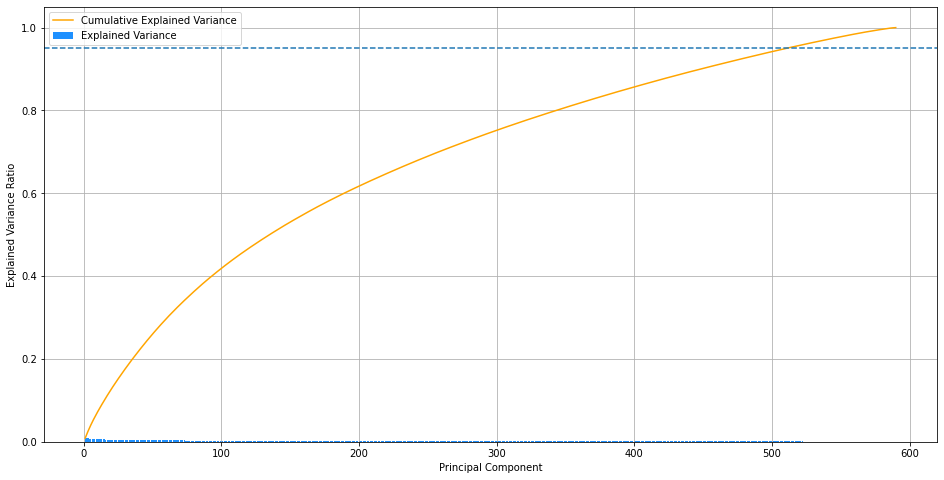

94.96% of variance explained by 509 components


In [120]:
scree_plot(pca)

We can see that the individual principal components explain very small amounts of variance themselves. Collectively, 509 PC's can explain around 95% of variance in the data. So if we reduce the number of dimensions by 81, we only lose 5% of variance. 

With the aim of reducing dimensionality in our data, we can check how many PC's are required for different levels of variance explained.

In [121]:
# Define levels of variance of interest
thresholds = [0.75, 0.8, 0.85, 0.9, 0.95, 1]
# Create dictionary for output
pc_var = {}

for i in thresholds:
  # Find the number of PC's required to explain each level of variance
  no_pc = np.where(abs(np.cumsum(pca.explained_variance_ratio_) - i) < 0.001)[0][0]
  # Record in a dictionary
  pc_var[i] = no_pc

# Convert dictionary to dataframe
pc_var_df = pd.DataFrame.from_dict(pc_var, orient='index', columns=['PC'])

# Add a column to summarise no. PC's as a proportion of total PC's
pc_var_df['PC_Prop'] = pc_var_df['PC'] / pca.n_components

# View results
pc_var_df

,PC,PC_Prop
0.75,297,0.50
0.80,342,0.58
0.85,391,0.66
0.90,447,0.76
0.95,509,0.86
1.00,586,0.99


We can see that the number of PC's required to explain variance at our selected thresholds sharply reduces with lower variance. For example, reducing the variance explained by 25% reduces the number of PC's by 50%. As we prefer lower dimensionality in our features, we also want to maintain most of the variance explained by our features. Hence, we will select a PC count of 391 - which reduces the number of PC's by 44% at the cost of 15% variance.


In [16]:
# Fit PCA with 391 PC's
pca = PCA(n_components=391)
pca.fit(tfidf_out.todense())

# Transform word vectors to PC's
pca_out = pca.transform(tfidf_out.todense())

# Check dimensions of transformed PC vectors
print('TFIDF dimensions: {}\nPC dimensions: {}'.format(tfidf_out.shape, pca_out.shape))

TFIDF dimensions: (147421, 590)
PC dimensions: (147421, 391)


In [123]:
# Check variance explained - about 85%
print('Variance explained: {:.2%}'.format(pca.explained_variance_ratio_.sum()))

Variance explained: 84.18%


In [98]:
# Look at the loading of each feature for the PC's
pc_loading = pd.DataFrame(pca.components_).transpose()

In [99]:
# Create function to extract important features for a PC
def get_key_features_PC(pc, word_features, n):
  # Get features with largest absolute coefficients
  pc_load = pc.nlargest(n).to_dict()
  pc_load.update(pc.nsmallest(n).to_dict())

  # Print out words that correspond to these features
  for word, load in pc_load.items():
    print('{}: {:.2}'.format(word_features[word], load))

In [100]:
# Get features with largest and smallest loading coefficients for first 2 PC's
for i in range(2):
  print('PC ', i+1)
  get_key_features_PC(pc_loading[i], tfidf.get_feature_names(), 3)
  print('\n')

PC  1
thank: 0.83
so: 0.15
you: 0.1
tonight: -0.28
pm: -0.2
news: -0.09


PC  2
tonight: 0.62
pm: 0.42
thank: 0.28
be: -0.28
do: -0.14
it: -0.11




The 1st PC is heavily influenced by the presence of the word 'thank' in a tweet. The rest of the features are not as significant but it appears the combination of the words 'tonight' and 'pm', which can co-occur frequently, have the highest negative loadings for the PC.

For the 2nd PC, the opposite occurs with 'tonight' and 'pm' having a very high positive loading, and interestingly, 'thank' has the 3rd highest positive loading.

These words may be significant as they capture the most variance in the word vectors. Variance in word vectors can stem from words that appear frequently in some texts and rarely in others. We can check the frequency of the significant words in the tweets.

In [101]:
# Check frequency of influential words in tweets
from nltk import FreqDist
all_words = ' '.join(tw_final.tolist()) # join all rows into one list
freq_words = FreqDist(all_words.split()) # split each word as separate items in a list
freq_words.most_common(15)

[('be', 13843),
 ('it', 11354),
 ('tonight', 9847),
 ('get', 8863),
 ('we', 8018),
 ('do', 7999),
 ('news', 7776),
 ('all', 7686),
 ('up', 7568),
 ('today', 7236),
 ('go', 7196),
 ('pm', 7050),
 ('what', 6684),
 ('an', 6578),
 ('he', 6536)]

In [102]:
freq_words.get('thank')

5209

We can see that 'tonight' and 'pm' are both in the 15 most common words, while 'thank' also appears relatively frequently. We can also see that most of the words in the top 15 are similar to stopwords, for example, 'be' and 'it'. 

This makes our results appear reasonable, as words that appear relatively often across the tweets but not too common, are more likely to have higher loading in PCA, as they have higher variance in frequency across the word vectors.

## c. K-means clustering

To better understand our data, we can use K-means clustering to identify whether there are underlying groups of tweets or words that are similar.

Ideally, our results from K-means clustering show that there are distinct groups of tweets in our data - whether it is characterised by the words they use or the frequency of words. This may give rise to 'topics' that users tweet about which can even be used as a separate feature in our further modelling.

As K-means uses a distance measure, such as Euclidean distance, to compute similarity, this makes applying K-means to high dimensional data more difficult. Hence, we will apply K-means to our PCA transformed word vectors which has much a lower dimension than our original TF-IDF vectors.

In [124]:
# Define function to create an Elbow plot for selecting number of clusters
import matplotlib.pyplot as plt
def plot_kmeans(km_out, ylabel='Within cluster SSE'):
  clusters = list(km_out.keys())
  km_score = list(km_out.values())

  plt.figure(figsize=(16,6))
  plt.plot(clusters, km_score)
  plt.xlabel('Number of Clusters')
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.show()

To determine the number of clusters, we will fit K-means on a range of clusters from 2 to 20 and use the elbow method to visually identify a suitable number of clusters. The metrics we will use are:
* 'Within cluster sum of squares', which describes how dispersed observations in 1 cluster from the centre
* the Davies Bouldin Score, which is an internal validation metric which measures the average similarity of a cluster its the closest cluster
* the Silhouette Score, is another internal validation metric that measures how individual observations are similar to their own clusters compared to others.  

For the 1st and 2nd metrics, a lower value is better, which means that in the elbow graph, we are looking for a 'bend' in the curve where the metric is initially reducing sharper and after the bend, begins to plateau. For the Silhouette Score, a higher value is better and we are looking for a 'peak' in the scores.

For efficiency we use the `MiniBatchKMeans` implementation from SKLearn to identify the clusters, which is significantly quicker as it fits on minibatches of data but has variability in the result. After identifying the number of clusters we require, we will use `KMeans`, which takes in the entire dataset, to fit the final K-means clustering and confirm our result.

In [152]:
# Kmeans on PCA transformed word vectors
from sklearn.cluster import MiniBatchKMeans # much faster implementation of kmeans
from tqdm.notebook import tqdm_notebook # progress bar
from sklearn.metrics import davies_bouldin_score # internal validation metric
from sklearn.metrics import silhouette_score # internal validation metric

wss = {}
dbs = {}
silh = {}

# Run K-means for clusters 2 to 20
for k in tqdm_notebook(range(2, 21)):
  kmeans = MiniBatchKMeans(n_clusters=k, 
                           batch_size=20000, # use a large batch size to reduce variability
                           random_state=24) # set seed for reproducibility
  kmeans.fit(pca_out)
  wss[k] = kmeans.inertia_ # SSE of observations to their nearest cluster centre
  dbs[k] = davies_bouldin_score(pca_out, kmeans.labels_) # store dbs score for current k
  silh[k] = silhouette_score(pca_out, kmeans.labels_, sample_size=5000)

  0%|          | 0/19 [00:00<?, ?it/s]

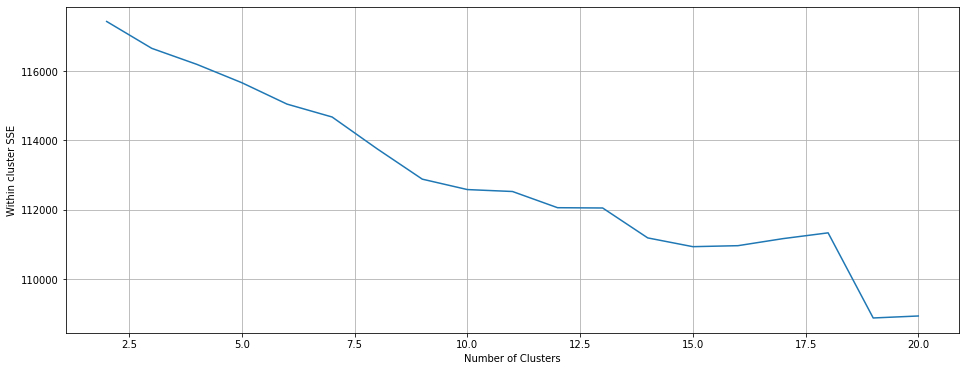

In [153]:
# Visualise Elbow graphs
plot_kmeans(wss)  

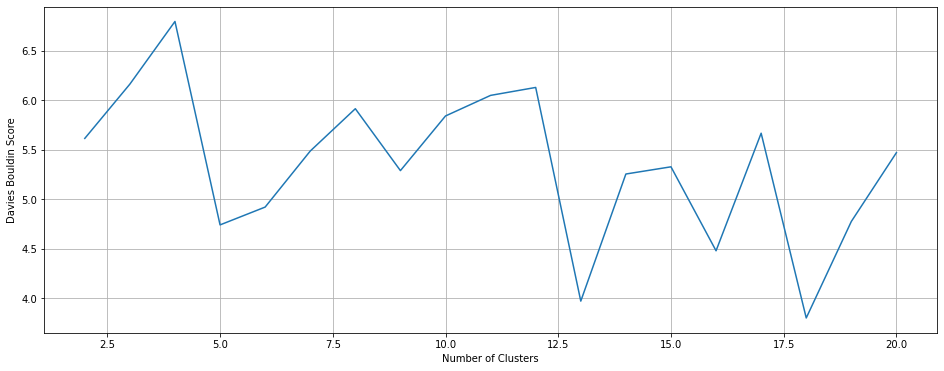

In [154]:
plot_kmeans(dbs, ylabel='Davies Bouldin Score')

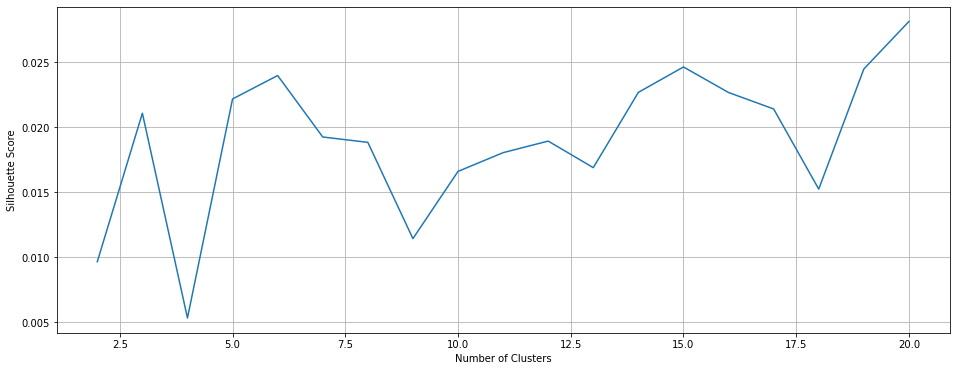

In [155]:
plot_kmeans(silh, ylabel='Silhouette Score')

From our Elbow graphs, the Within Cluster Sum of Squares continues to decrease without a noticeable elbow. This can be due to the high dimensionality of our data as points are generally quite far apart from each other and it is difficult to significantly reduce their distance from a centre in high dimensional space.

However, if we look at the Davies Bouldin Score and Silhouette Score, they both appear to have a peak at around 15 clusters - where the Davies Bouldin Score reaches minimum values around 15 clusters and the Silhouette Score reaches a maximum. 

Hence, we will select 15 clusters to use in K-means.

In [156]:
# Fit on PCA transformed vectors with 15 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15)
kmeans.fit(pca_out)

# Check metrics to see if they are in line with the previous graphs
print('K-means with {} clusters\nWSS: {:,.0f}\nDavies Bouldin: {:.2f}\nSilhouette: {:.4f}'.\
      format(kmeans.n_clusters, kmeans.inertia_, 
             davies_bouldin_score(pca_out, kmeans.labels_),
             silhouette_score(pca_out, kmeans.labels_, sample_size=10000)))

K-means with 15 clusters
WSS: 109,625
Davies Bouldin: 4.75
Silhouette: 0.0275


The metrics of our fitted K-means are relatively in line with the metrics in the graphs. We will now evaluate the quality of our clustering with respect to the sensibility of the clusters in our context of tweets, and quantitative measures.

## d. Evaluate clusters

To evaluate the quality of clustering, we can use internal valdation metrics which summarise the performance into 1 quantity. We already have used two of these metrics earlier in selecting the number of clusters - the Davies Bouldin Score and Silhouette Score. 

As mentioned earlier, the Davies Bouldin Score measures the average similarity of a cluster to its most similar cluster, where a lower score is better with a minimum value of 0. 

The Silhouette Score measures how similar a point is to its own cluster, compared to other clusters. Values range from -1 to 1, with a value of 1 indicating it is very similar to its own cluster and far away from other clusters, a value of 0 indicating that it is near the decision boundary between clusters, and a value less than 0 indicating it is more similar to another cluster. 

It would be computationally intensive to calculate the Silhouette Score for each individual observation (tweet), so instead we calculate the scores for a sample. The scores for all observations in the sample are averaged to return 1 value as the average Silhouette Score for the sample.

In [157]:
# From previous section
print('K-means with {} clusters\nWSS: {:,.0f}\nDavies Bouldin: {:.2f}\nSilhouette: {:.4f}'.\
      format(kmeans.n_clusters, kmeans.inertia_, 
             davies_bouldin_score(pca_out, kmeans.labels_),
             silhouette_score(pca_out, kmeans.labels_, sample_size=10000)))

K-means with 15 clusters
WSS: 109,625
Davies Bouldin: 4.75
Silhouette: 0.0301


In [159]:
# Calculate silhouette values
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(pca_out, kmeans.labels_) # 13 min

In [163]:
# Statistic summary of silhouette values - we see that our silhouette scores are
# quite low with about 25% that are negative
pd.DataFrame(sample_silhouette_values).describe()

,0
count,147421.00
mean,0.03
std,0.04
min,-0.09
25%,0.01
50%,0.01
75%,0.04
max,0.37


For n_clusters = 15 The average silhouette_score is : 0.02178043099987956


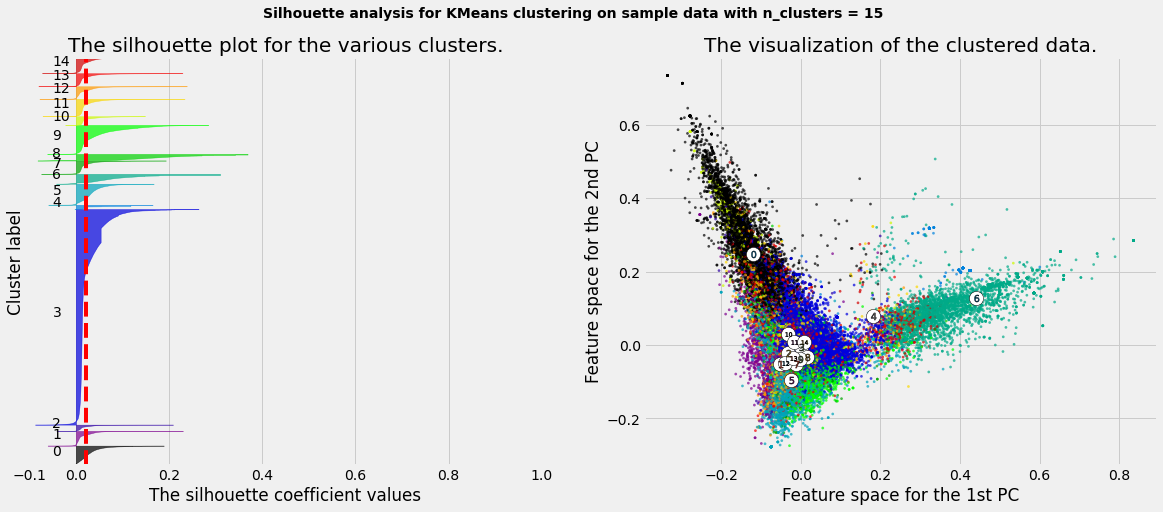

In [215]:
### Visualise silhouette scores across clusters 
# source: https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891
import matplotlib.cm as cm
n_clusters = 15

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(pca_out) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
# clusterer = KMeans(n_clusters=n_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(pca_out)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
# silhouette_avg = silhouette_score(pca_out, cluster_labels) # 10 min to reach this point - avg of silh samples?
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# silhouette_avg_n_clusters.append(silhouette_avg)
# Compute the silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])    

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(pca_out[:, 0], pca_out[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st PC")
ax2.set_ylabel("Feature space for the 2nd PC")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
              fontsize=14, fontweight='bold')
    
plt.show()

plt.style.use("fivethirtyeight")

From the silhouette chart, we can see that most silhouette values are below 0.2 which is relatively low. This indicates that our clusters are not well separated and some observations can be attributed to other clusters, as shown by the abundance of negative silhoeutte scores, particularly in Cluster 3. This can be seen in the right-hand side visualisation of the clustered data, where all cluster centroids, apart from clusters 0, 4 and 6, are congregated together in a similar area. 

This makes differentiating between these clusters difficult and suggests that it our tweets data may not be easily separated into clusters. There are a few observations with relatively high silhouette scores, particularly in Cluster 8, however the value still is not very high being less than 0.4. Overall, our clustering results do not look very good from an internal validation perspective. We will also investigate the actual words and tweets that are being clustered together.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


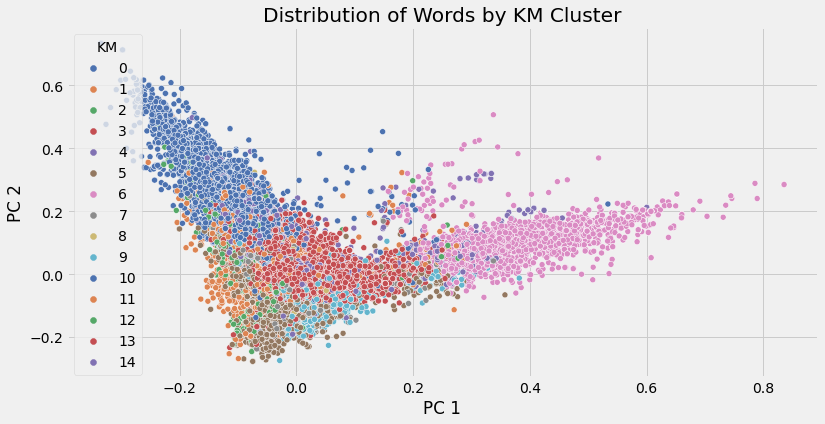

In [177]:
# Visualise clusters across first two PC's
# import seaborn as sns

# km_df = pd.DataFrame({'PC1': pca_out[:,0], 'PC2': pca_out[:,1], 'KM': kmeans.labels_})

# plt.figure(figsize=(12,6))
# sns.scatterplot(km_df['PC1'], km_df['PC2'], hue=km_df['KM'], palette='deep')
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('Distribution of Words by KM Cluster')
# # Labeling the clusters
# centers = kmeans.cluster_centers_
# # Draw white circles at cluster centers
# ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#             c="white", alpha=1, s=200, edgecolor='k')

# for i, c in enumerate(centers):
#     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                 s=50, edgecolor='k')

In [178]:
# Structure cleaned tokens as a dataframe
words_df = tw_wordnet.to_frame()

# Append KMeans Cluster
words_df['KM_Cluster'] = kmeans.labels_

# Look at proportion of tweets in each cluster
words_df.KM_Cluster.value_counts(normalize=True)

3    0.53
9    0.07
5    0.05
0    0.05
11   0.04
14   0.04
1    0.04
7    0.03
13   0.03
12   0.03
6    0.02
10   0.02
8    0.02
2    0.02
4    0.01
Name: KM_Cluster, dtype: float64

We can see that more than half the tweets are allocated to Cluster 3. This may be a sign the K-means algorithm has struggled to break apart our data into clear clusters.

We will have a closer look at the words and tweets that have been clustered together. One method of text visualisation is making a wordcloud, where the size of words is mapped to their frequency. We can gain insight into the common words by creating wordclouds for each cluster.

In [179]:
# Filter for words only in tfidf features - 7min
word_feat = tfidf.get_feature_names()
words_df['tweet_text'] = words_df['tweet_text'].apply(lambda x: [word for word in x if word not in word_feat])

In [187]:
# Create function to generate wordcloud of frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(words_df, cluster_col, cluster):
  # Concatenate all words in cluster into 1 string as input
  words = words_df.loc[words_df[cluster_col]==cluster, 'tweet_text'].apply(lambda x: ' '.join(x))
  input_string = ' '.join(words.tolist())

  # Create and show wordcloud
  wordcloud = WordCloud(max_words=100, background_color="white").generate(input_string)
  plt.figure(figsize=(9,6))
  plt.axis('off')
  plt.imshow(wordcloud, interpolation='bilinear')

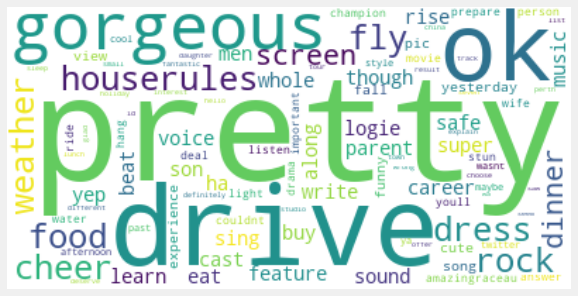

In [188]:
# Create wordcloud of text in Cluster 3
# Major words are pretty, gorgeous, drive
create_wordcloud(words_df, 'KM_Cluster', cluster=3)

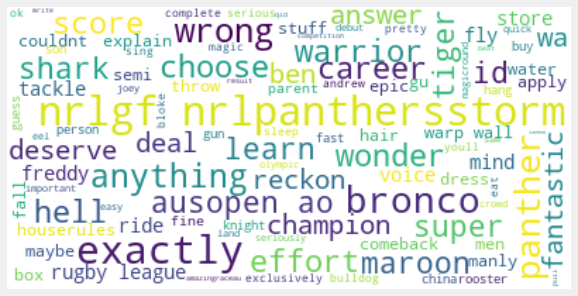

In [189]:
# Cluster 9 could be about NRL or sport-themed with a number of teams being 
# mentioned and also ausopen and champion
create_wordcloud(words_df, 'KM_Cluster', cluster=9)

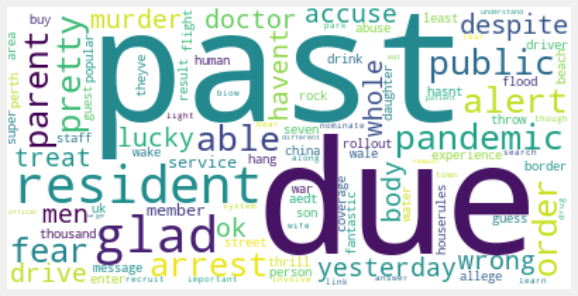

In [190]:
# Cluster 5 looks like it could involve communication about the Covid-19 pandemic
# with words such as pandemic, resident, alert, due and past
create_wordcloud(words_df, 'KM_Cluster', cluster=5)

In [191]:
# Look at samples of tweets from each cluster
for i in range(max(words_df.KM_Cluster)+1):
    print('Cluster', i)
    for row in words_df.loc[words_df.KM_Cluster == i, 'tweet_text'].sample(3):
        print(row)
    print('\n')

Cluster 0
['reason']
['suspect', 'emerge', 'halifaxretribution']
['u', 'saliva', 'produce', 'lifetime', 'healthyplayground']


Cluster 1
['super', 'blood', 'moon', 'treat', 'sky']
['recently', 'unite', 'kingdom', 'mutate', 'strain']
['eligible', 'astrazeneca', 'gps']


Cluster 2
['brad', 'fin', 'criticise', 'umpire', 'north', 'fin']
['derby', 'finch', 'marsh', 'bat']
['tribute', 'bon', 'frontman', 'greatest', 'rock', 'n', 'roll', 'export', 'burst', 'brick', 'wall', 'acdc', 'lane', 'liveat']


Cluster 3
['stokehouse', 'kilda']
['expensive', 'childcare', 'equality']
['jules', 'capture', 'facebook', 'profile', 'picture', 'ali', 'bacheloretteau']


Cluster 4
['uh', 'trouble', 'v']
['comment']
[]


Cluster 5
['asada', 'dank', 'evidence', 'testso', 'tie']
['hillcrest', 'christian', 'college', 'rock', 'tactic', 'teacher', 'bully', 'blame', 'master']
[]


Cluster 6
['gaz', 'memory', 'geelong', 'faithful']
['shookran', 'u', 'tik', 'tok']
['fabulous']


Cluster 7
['wasnt']
['riley', 'meredith', 

In [193]:
# Check most common words in each cluster
from nltk import FreqDist
def get_common_words(words_df, k, n=7):
  # Concatenate tweet text in selected cluster
  word_list = words_df.loc[words_df.KM_Cluster==k, 'tweet_text'].apply(lambda txt: ' '.join(txt)).tolist()
  all_words = ' '.join(word_list)
  # Get frequency of words in text
  freq_words = FreqDist(all_words.split())
  return freq_words.most_common(n)

# Get 7 most common words in each cluster
common_words_cluster = {'Cluster '+str(k): get_common_words(words_df, k) for k in range(words_df.KM_Cluster.max() + 1)}

# View results as dataframe
pd.DataFrame(common_words_cluster)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14
0,"(u, 303)","(auspol, 273)","(liveat, 72)","(u, 2234)","(livestream, 400)","(u, 305)","(u, 347)","(u, 224)","(spoiler, 149)","(u, 336)","(blockhead, 230)","(u, 270)","(u, 159)","(u, 170)","(u, 416)"
1,"(v, 168)","(u, 183)","(u, 65)","(x, 554)","(goliath, 32)","(i, 121)","(x, 182)","(i, 87)","(bay, 145)","(i, 131)","(oblock, 118)","(talent, 90)","(crash, 78)","(absolute, 101)","(x, 75)"
2,"(sneak, 104)","(budget, 125)","(north, 61)","(v, 546)","(govern, 27)","(s, 60)","(kind, 102)","(himself, 68)","(whoshotcharlotte, 143)","(nrlgf, 92)","(block, 117)","(i, 86)","(allegedly, 77)","(audience, 82)","(greatest, 61)"
3,"(peek, 99)","(border, 119)","(resident, 56)","(i, 543)","(supernerd, 20)","(past, 56)","(appreciate, 79)","(trump, 67)","(hunter, 68)","(nrlpanthersstorm, 80)","(u, 114)","(ticket, 81)","(suffer, 69)","(average, 80)","(sale, 55)"
4,"(aest, 70)","(thelatest, 115)","(melbweather, 55)","(s, 409)","(chaser, 18)","(due, 56)","(glad, 60)","(wasnt, 64)","(ash, 67)","(exactly, 73)","(luke, 105)","(involve, 61)","(arrest, 60)","(extraordinary, 75)","(once, 47)"
5,"(aedt, 67)","(outbreak, 109)","(outbreak, 48)","(m, 323)","(u, 18)","(a, 56)","(xxx, 50)","(president, 59)","(mason, 63)","(bronco, 73)","(bathroom, 82)","(couldnt, 51)","(court, 60)","(provide, 72)","(i, 45)"
6,"(heat, 67)","(wale, 107)","(v, 45)","(a, 317)","(hello, 17)","(resident, 54)","(lisa, 42)","(belief, 47)","(retweet, 61)","(v, 71)","(te, 81)","(v, 44)","(driver, 53)","(emotional, 67)","(smile, 44)"


Looking at the most common words per cluster, we notice that there are potential themes in each cluster. 
* For Cluster 1, common words are 'auspol', 'budget', 'border', 'thelatest', which all are themed around the country and potentially related to news of national security. The sentiments in this cluster can be linked to stock price performance, as any risks in the macroeconomic or national security area would be a driver for deterring stock price growth.
* Common words in Cluster 7 are 'himself', 'trump', 'president', which relates back to the original idea of President Trump's tweets influences movements in stock prices.
* Cluster 9 has themes around NRL, which does not have an obvious link with share prices of TV networks. 
* Cluster 10 has themes around the TV show 'The Block'. From our research in the TV industry, we found that the main driver in financial performance was ad revenue which is driven by the quality of shows that a TV network has. Greater online activity and buzz about a show can have connections with financial performance and perceived value of a TV network, thus relating to its stock price.
* Cluster 12 has themes around tragic news which can have systemic implications for the stock market as a whole. 

However, from our early indication from the poor silhouette scores, looking at sample tweets in each cluster also indicates that the clustering of tweets is not very distinct. For example, in Cluster 9 we can see that overall, the main theme is around NRL, however there are tweets such as 'zac rockgod' that seem unrelated to NRL.

We also notice some words that appear across most clusters, such as 'u'. They look like potential stopwords which show that further cleaning may be required.

Overall, our clusters look rather unreliable to use in the context of identifying topic areas in tweets, especially for future modelling of stock prices. This is driven by the poor quality of clustering, where many clusters are so similar that they are indistinguishable from each other.

# Question 4

## a. Creating Response Variable

### Load and check data

In [216]:
# Load stock price data for Channel 7
stock = pd.read_csv('DAA 2021 S2 Assignment - data SVW prices.csv')
stock

,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
0,SVW,ASX,1/07/2020T10:00:00,1/07/2020T0:00:00,1739.00,1767.00,1730.00,1762.00,22760,397848.47,224
1,SVW,ASX,1/07/2020T10:10:00,1/07/2020T0:10:00,1764.00,1768.00,1743.00,1766.00,33921,596029.80,411
2,SVW,ASX,1/07/2020T10:20:00,1/07/2020T0:20:00,1766.00,1768.00,1758.00,1764.00,23738,418054.19,307
3,SVW,ASX,1/07/2020T10:30:00,1/07/2020T0:30:00,1764.00,1767.00,1756.00,1759.00,21058,370966.84,323
4,SVW,ASX,1/07/2020T10:40:00,1/07/2020T0:40:00,1760.00,1762.00,1754.00,1757.00,8933,157221.43,130
...,...,...,...,...,...,...,...,...,...,...,...
9109,SVW,ASX,23/06/2021T15:20:00,23/06/2021T5:20:00,2104.50,2105.00,2104.00,2104.50,17097,359801.58,115
9110,SVW,ASX,23/06/2021T15:30:00,23/06/2021T5:30:00,2104.50,2105.00,2101.00,2104.50,25665,539944.10,267
9111,SVW,ASX,23/06/2021T15:40:00,23/06/2021T5:40:00,2104.50,2105.00,2102.00,2103.00,45037,947459.70,362
9112,SVW,ASX,23/06/2021T15:50:00,23/06/2021T5:50:00,2104.00,2105.00,2102.00,2104.00,51982,1093652.18,414


In [ ]:
# Check column types and missing values
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9114 entries, 0 to 9113
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Code          9114 non-null   object 
 1   Exchange      9114 non-null   object 
 2   SrcTime       9114 non-null   object 
 3   GMT           9114 non-null   object 
 4   Open          9114 non-null   float64
 5   High          9114 non-null   float64
 6   Low           9114 non-null   float64
 7   Close         9114 non-null   float64
 8   Volume        9114 non-null   int64  
 9   Value         9114 non-null   float64
 10  Transactions  9114 non-null   int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 783.4+ KB


In [ ]:
# Check summary statistics
stock.describe()

,Open,High,Low,Close,Volume,Value,Transactions
count,9114.000000,9114.000000,9114.000000,9114.000000,9.114000e+03,9.114000e+03,9114.000000
mean,2083.066820,2086.703972,2079.403171,2083.073458,1.416493e+04,2.924586e+05,197.567588
std,216.852388,216.809827,216.928580,216.834839,2.644853e+04,5.552493e+05,111.201974
min,1655.000000,1659.000000,1653.000000,1655.000000,1.330000e+02,3.088120e+03,1.000000
25%,1873.125000,1877.000000,1869.000000,1873.250000,5.180250e+03,1.074334e+05,123.000000
50%,2126.000000,2129.000000,2123.750000,2126.000000,8.465500e+03,1.736197e+05,172.000000
75%,2273.000000,2277.000000,2270.000000,2273.000000,1.422175e+04,2.917357e+05,242.000000
max,2423.000000,2425.000000,2419.000000,2425.000000,1.068486e+06,2.404094e+07,1920.000000


In [ ]:
# Check number of unique values
stock.nunique()

Code               1
Exchange           1
SrcTime         9114
GMT             9113
Open            1261
High            1101
Low             1117
Close           1202
Volume          7440
Value           9114
Transactions     607
dtype: int64

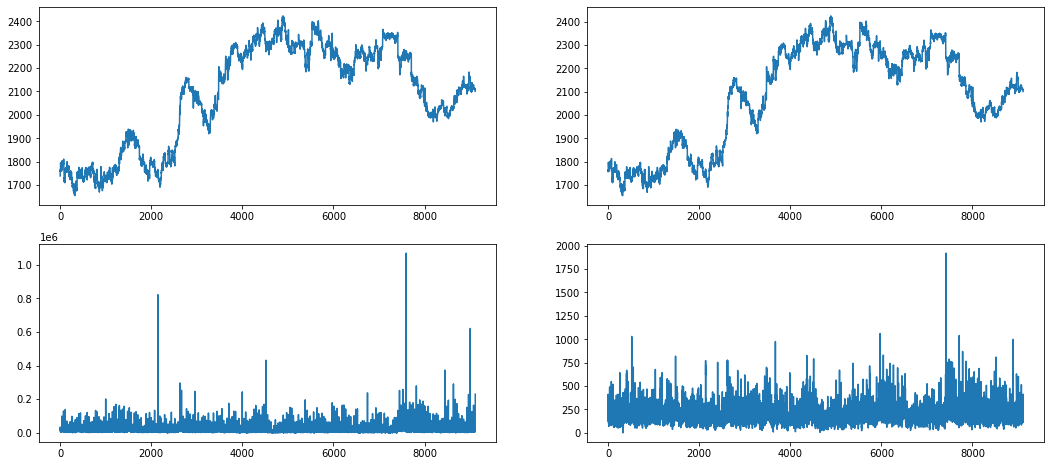

In [ ]:
# Visualise features
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18,8), nrows=2, ncols=2)
ax[0,0].plot(stock.Open)
ax[0,1].plot(stock.Close)

ax[1,0].plot(stock.Volume)
ax[1,1].plot(stock.Transactions)

* Stock prices fluctuate throughout the day - a moving average can be used to smooth volatility and allow for lag time for investors to respond to 'influential' tweets.
* Volume can be an interesting response variable to use, as there may be higher trading activity following 'influential' tweets.

In [218]:
### Data cleaning
# Convert date features to datetime
stock['SrcTime'] = pd.to_datetime(stock.SrcTime, dayfirst=True)
stock['GMT'] = pd.to_datetime(stock.GMT, dayfirst=True)

In [219]:
# Check trading hours
stock['TradeHour'] = stock.SrcTime.dt.to_period("h")
stock.TradeHour.value_counts()

2021-03-01 13:00    6
2020-08-17 11:00    6
2020-11-04 10:00    6
2020-08-11 11:00    6
2020-11-05 10:00    6
                   ..
2021-05-14 16:00    1
2020-11-24 16:00    1
2020-11-25 16:00    1
2021-05-13 16:00    1
2021-06-02 16:00    1
Freq: H, Name: TradeHour, Length: 1726, dtype: int64

In [220]:
# Create trade day variable
stock['TradeDay'] = stock.SrcTime.dt.to_period("d")

In [221]:
# Look at last trades of the day
stock.groupby('TradeDay').SrcTime.last().apply(lambda time: str(time)[-8:]).value_counts()

16:10:00    245
14:10:00      2
10:20:00      1
Name: SrcTime, dtype: int64

In [222]:
# Look at first trades of the day
stock.groupby('TradeDay').GMT.first().apply(lambda time: str(time)[-8:]).value_counts()

23:00:00    123
00:00:00    120
00:10:00      3
23:10:00      2
Name: GMT, dtype: int64

In [ ]:
# First trade looks like at 10am
# Last trade looks like at 4:10pm

In [ ]:
# Create indicator for stock price movement
# If Close > Open: Increase
# If Close < Open: Decrease
# If Close == Open: Neutral
stock

,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
0,SVW,ASX,2020-07-01 10:00:00,2020-07-01 00:00:00,1739.0,1767.0,1730.0,1762.0,22760,397848.475,224
1,SVW,ASX,2020-07-01 10:10:00,2020-07-01 00:10:00,1764.0,1768.0,1743.0,1766.0,33921,596029.795,411
2,SVW,ASX,2020-07-01 10:20:00,2020-07-01 00:20:00,1766.0,1768.0,1758.0,1764.0,23738,418054.190,307
3,SVW,ASX,2020-07-01 10:30:00,2020-07-01 00:30:00,1764.0,1767.0,1756.0,1759.0,21058,370966.835,323
4,SVW,ASX,2020-07-01 10:40:00,2020-07-01 00:40:00,1760.0,1762.0,1754.0,1757.0,8933,157221.430,130
...,...,...,...,...,...,...,...,...,...,...,...
9109,SVW,ASX,2021-06-23 15:20:00,2021-06-23 05:20:00,2104.5,2105.0,2104.0,2104.5,17097,359801.575,115
9110,SVW,ASX,2021-06-23 15:30:00,2021-06-23 05:30:00,2104.5,2105.0,2101.0,2104.5,25665,539944.100,267
9111,SVW,ASX,2021-06-23 15:40:00,2021-06-23 05:40:00,2104.5,2105.0,2102.0,2103.0,45037,947459.705,362
9112,SVW,ASX,2021-06-23 15:50:00,2021-06-23 05:50:00,2104.0,2105.0,2102.0,2104.0,51982,1093652.180,414


Our tweet data is recorded in UTC time. This matches with GMT in our stock data. We will look to match the times of tweets and stock prices using the GMT record. This is easier than converting the tweet times to Sydney time, as the time difference is inconsistent over the year due to Daylight Savings.

### Create response variable from stock price

Stock prices are measured at 10 min intervals, while tweets occur erratically. It is hard to assign 1 tweet to 1 stock price measurement, so the effect of tweets occuring in a time period would have a 'mixed' aggregate effect on stock prices. To handle this complexity, we consider our response variable as **price changes on an hourly basis** - whether it increases, decreases or remains neutral. 

To create our response variable, we need to make the following assumptions:
* Tweets that occur within trading hour will be considered features for the price change (target).
* This assumes that investors react to tweets within the hour of trading, which can be from 1 minute to 60 mins.

Hence, from the stock data we only require the Opening price of the trading period, as we measure movements across the hour, and the trading time in GMT, to match our tweet data.

In [223]:
# We only need time and opening price (consider 1st price on the hour)
stock = stock[['GMT', 'Open']]

In [226]:
# Create trading hours variable
stock['TradeHour'] = stock.GMT.dt.to_period("h").copy()

# Select the first trade in the hour
print('Expect result to have {} rows'.format(stock.TradeHour.nunique()))
stock = stock.groupby('TradeHour').first() # .append(stock.groupby('TradeHour').last())
stock = stock.reset_index()
stock.shape

Expect result to have 1726 rows


(1726, 3)

In [227]:
# Get next closing price in the hour
stock = stock.sort_values('GMT')
stock['Next_Open'] = stock.Open.shift(periods=-1)

# remove last record - no available response for price movement
stock = stock[:-1]

In [228]:
stock[10:20]

,TradeHour,GMT,Open,Next_Open
10,2020-07-02 03:00,2020-07-02 03:00:00,1800.00,1797.00
11,2020-07-02 04:00,2020-07-02 04:00:00,1797.00,1794.00
12,2020-07-02 05:00,2020-07-02 05:00:00,1794.00,1788.00
13,2020-07-02 06:00,2020-07-02 06:10:00,1788.00,1796.00
14,2020-07-03 00:00,2020-07-03 00:00:00,1796.00,1779.00
15,2020-07-03 01:00,2020-07-03 01:00:00,1779.00,1728.00
16,2020-07-03 02:00,2020-07-03 02:00:00,1728.00,1724.00
17,2020-07-03 03:00,2020-07-03 03:00:00,1724.00,1720.00
18,2020-07-03 04:00,2020-07-03 04:00:00,1720.00,1724.00
19,2020-07-03 05:00,2020-07-03 05:00:00,1724.00,1740.00


In [229]:
# Calculate Price Change over the hour
stock['Price_Chg'] = stock['Next_Open'] - stock['Open']

# Look at instances where the price change is minimal
stock.loc[stock.Price_Chg.abs() < 2]

,TradeHour,GMT,Open,Next_Open,Price_Chg
3,2020-07-01 03:00,2020-07-01 03:00:00,1769.50,1770.00,0.50
9,2020-07-02 02:00,2020-07-02 02:00:00,1800.00,1800.00,0.00
31,2020-07-07 03:00,2020-07-07 03:00:00,1776.00,1777.00,1.00
32,2020-07-07 04:00,2020-07-07 04:00:00,1777.00,1777.00,0.00
34,2020-07-07 06:00,2020-07-07 06:10:00,1766.00,1767.00,1.00
...,...,...,...,...,...
1682,2021-06-15 05:00,2021-06-15 05:00:00,2121.00,2121.00,0.00
1686,2021-06-16 02:00,2021-06-16 02:00:00,2122.00,2123.00,1.00
1689,2021-06-16 05:00,2021-06-16 05:00:00,2121.00,2120.00,-1.00
1697,2021-06-17 06:00,2021-06-17 06:10:00,2103.00,2103.00,0.00


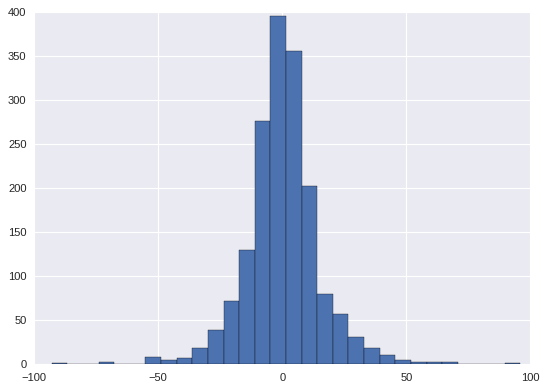

In [239]:
# Look at distribution of price changes 
# Looks like a normal centred around 0
plt.style.use('seaborn-notebook')
stock.Price_Chg.hist(bins=30)

In [241]:
# Check numerical summary
stock.Price_Chg.describe()

count   1725.00
mean       0.21
std       15.16
min      -93.00
25%       -7.00
50%        0.00
75%        7.00
max       96.00
Name: Price_Chg, dtype: float64

In [242]:
# Split price change into 3 relatively equal buckets
# Reasoning is that small price changes mean negligible effects from any influece
# such as tweets. We want to capture the significant price movements, separate
# to minimal movements.
stock['Price_Chg_Bucket'] = pd.qcut(stock.Price_Chg, q = 3)
stock['Price_Chg_Bucket'].value_counts()

(-93.001, -4.0]    603
(4.5, 96.0]        566
(-4.0, 4.5]        556
Name: Price_Chg_Bucket, dtype: int64

In [243]:
# Transform Price Movements to a categorical Target feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stock['target'] = le.fit_transform(stock['Price_Chg_Bucket'])

In [244]:
stock.describe()

,Open,Next_Open,Price_Chg,target
count,1725.00,1725.00,1725.00,1725.00
mean,2082.80,2083.01,0.21,0.98
std,216.98,216.82,15.16,0.82
min,1655.00,1655.00,-93.00,0.00
25%,1873.00,1873.00,-7.00,0.00
50%,2127.00,2127.00,0.00,1.00
75%,2272.00,2272.00,7.00,2.00
max,2420.00,2420.00,96.00,2.00


Our response variable is created with three buckets - 'Decrease', 'Neutral' and 'Increase' with relatively equal proportions of each response. Now we need to join our response variable with the tweets data which has the features.

### Join response with tweets

In [245]:
# Check time period of stock prices and response variables
print(stock.GMT.min())
print(stock.GMT.max())

2020-07-01 00:00:00
2021-06-23 05:00:00


In [248]:
# Filter for tweets from 2020-07
tweets = df.loc[(df.tweet_post_time >= stock.GMT.min()) & (df.tweet_post_time < stock.GMT.max())]
print(tweets.tweet_post_time.min()) # check
print(tweets.tweet_post_time.max())
print(tweets.shape)

2020-07-01 00:50:00
2021-06-23 04:59:00
(46673, 14)


Problem: we don't have a one-to-one mapping of the target variable with our features. We need to map the tweet post time to the stock price time, and associated target variable.

Steps:
1. Get hour that each tweet is made. 
2. Create a mapping table of hour and target where:
* if a trade was made in the hour, then the target is simply whether the direction of price movement after the hour.
* if no trade was made in the hour, then the tweet is considered to influence the price movement at the next trade.
i.e. tweet is at 6pm, the next trade is at 10am the next day. The target is the price movement at 10am from the previous record.
* Another example, is if no trades or prices are recorded for a whole day, then tweets made during the day are assumed to influence the next trading event. 
For example, no trades were made on Monday and the next trade is at 10am Tuesday. All tweets during Monday are assigned a target variable of the price movement at 10am Tuesday.  

This results in a table with columns 'Hour' and 'Target' - where the `tweetposthour` is joined with the table to obtain the desired target column.

In [249]:
# Get each hour of the day across the trading period
from datetime import timedelta
total_hours = (stock.GMT.max() - stock.GMT.min()).total_seconds() / 3600

hours_list = [stock.GMT.min() + timedelta(hours=i) for i in range(int(total_hours+1))]
print('Max hours', max(hours_list)) # looks good! 
print('Last stock trade', stock.GMT.max())

Max hours 2021-06-23 05:00:00
Last stock trade 2021-06-23 05:00:00


In [250]:
hours_map = pd.DataFrame(hours_list, columns=['Time'])
hours_map['Hour'] = hours_map.Time.dt.to_period("h")

hours_map = pd.merge(hours_map, stock[['TradeHour', 'target']], left_on='Hour', right_on='TradeHour', how='left')

In [251]:
# check all targets were captured
print('Expect {} rows'.format(len(stock)))
hours_map.loc[~hours_map.TradeHour.isna()]  # ok!

Expect 1725 rows


,Time,Hour,TradeHour,target
0,2020-07-01 00:00:00,2020-07-01 00:00,2020-07-01 00:00,2.00
1,2020-07-01 01:00:00,2020-07-01 01:00,2020-07-01 01:00,2.00
2,2020-07-01 02:00:00,2020-07-01 02:00,2020-07-01 02:00,0.00
3,2020-07-01 03:00:00,2020-07-01 03:00,2020-07-01 03:00,1.00
4,2020-07-01 04:00:00,2020-07-01 04:00,2020-07-01 04:00,0.00
...,...,...,...,...
8569,2021-06-23 01:00:00,2021-06-23 01:00,2021-06-23 01:00,1.00
8570,2021-06-23 02:00:00,2021-06-23 02:00,2021-06-23 02:00,0.00
8571,2021-06-23 03:00:00,2021-06-23 03:00,2021-06-23 03:00,1.00
8572,2021-06-23 04:00:00,2021-06-23 04:00,2021-06-23 04:00,0.00


In [252]:
# Assign missing values the next recorded target value
# e.g. no trade at 6pm, the next trade is at 10am the next day. The target is
# the price movement at 10am
hours_map.target.fillna(method='bfill', inplace=True)

In [253]:
# Create day variable for checking
hours_map['Day'] = hours_map.Time.dt.to_period("d") 

# looks good!
hours_map.loc[(hours_map.Day == '2020-07-01') | (hours_map.Day == '2020-07-02')]

,Time,Hour,TradeHour,target,Day
0,2020-07-01 00:00:00,2020-07-01 00:00,2020-07-01 00:00,2.00,2020-07-01
1,2020-07-01 01:00:00,2020-07-01 01:00,2020-07-01 01:00,2.00,2020-07-01
2,2020-07-01 02:00:00,2020-07-01 02:00,2020-07-01 02:00,0.00,2020-07-01
3,2020-07-01 03:00:00,2020-07-01 03:00,2020-07-01 03:00,1.00,2020-07-01
4,2020-07-01 04:00:00,2020-07-01 04:00,2020-07-01 04:00,0.00,2020-07-01
5,2020-07-01 05:00:00,2020-07-01 05:00,2020-07-01 05:00,2.00,2020-07-01
6,2020-07-01 06:00:00,2020-07-01 06:00,2020-07-01 06:00,2.00,2020-07-01
7,2020-07-01 07:00:00,2020-07-01 07:00,NaT,0.00,2020-07-01
8,2020-07-01 08:00:00,2020-07-01 08:00,NaT,0.00,2020-07-01
9,2020-07-01 09:00:00,2020-07-01 09:00,NaT,0.00,2020-07-01


In [254]:
# Check another day
hours_map.loc[hours_map.Day == '2021-06-22']

,Time,Hour,TradeHour,target,Day
8544,2021-06-22 00:00:00,2021-06-22 00:00,2021-06-22 00:00,0.00,2021-06-22
8545,2021-06-22 01:00:00,2021-06-22 01:00,2021-06-22 01:00,2.00,2021-06-22
8546,2021-06-22 02:00:00,2021-06-22 02:00,2021-06-22 02:00,1.00,2021-06-22
8547,2021-06-22 03:00:00,2021-06-22 03:00,2021-06-22 03:00,1.00,2021-06-22
8548,2021-06-22 04:00:00,2021-06-22 04:00,2021-06-22 04:00,1.00,2021-06-22
8549,2021-06-22 05:00:00,2021-06-22 05:00,2021-06-22 05:00,2.00,2021-06-22
8550,2021-06-22 06:00:00,2021-06-22 06:00,2021-06-22 06:00,0.00,2021-06-22
8551,2021-06-22 07:00:00,2021-06-22 07:00,NaT,0.00,2021-06-22
8552,2021-06-22 08:00:00,2021-06-22 08:00,NaT,0.00,2021-06-22
8553,2021-06-22 09:00:00,2021-06-22 09:00,NaT,0.00,2021-06-22


In [255]:
# Hour to response or target variable looks reasonable
# Select only the Hour and target columns
hours_map = hours_map[['Hour', 'target']]
# Check summary - in line with previous summary
hours_map.describe()

,target
count,8574.00
mean,1.06
std,0.88
min,0.00
25%,0.00
50%,1.00
75%,2.00
max,2.00


In [257]:
## Time to join with tweet features!!
# Get hour of tweet
tweets['TweetHour'] = tweets.tweet_post_time.dt.to_period("h")
# Get day of tweet
tweets['TweetDay'] = tweets.tweet_post_time.dt.to_period("d")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [258]:
# Join response based on hour
# Assume that tweets in the hour - have a quick response in the stock price so
# any impact is also realised in the hour
print(tweets.shape)
tweets = pd.merge(tweets.reset_index(), hours_map, 
                 left_on = 'TweetHour', right_on = 'Hour',
                 how = 'left', indicator = True)

# For overnight trades - all tweets in the day or night before the next opening
# day
print(tweets.shape)
tweets._merge.value_counts() # nice - all tweets mapped

(46673, 16)
(46673, 20)


both          46673
right_only        0
left_only         0
Name: _merge, dtype: int64

In [259]:
tweets.set_index('index', inplace=True) # keep original indices to join word features later

In [260]:
# Proportions have slightly changed from original stock data - more weight in increases/decreases
# should be ok
tweets.target.value_counts(normalize=True)

0.00   0.37
2.00   0.37
1.00   0.27
Name: target, dtype: float64

In [267]:
# Save tweets plus target (open price movement)
pickle.dump(tweets, open('tweets_w_response.pkl', 'wb'))

## Pre-requisite to b. & c.

Before we start modelling, we need to take necessary pre-requisite steps. The first is to split our data into training and testing, as predictive performance is a primary goal, we split out a test set to have a final evaluation of our model's predictive performance.

The second step is exploratory data analysis around our features. We will have a brief look at some of the features in our data and see if there are early signs of relationships between our features and our response.

### Train-test split

In [9]:
# import pickle
tweets = pickle.load(open('tweets_w_response.pkl', 'rb'))

In [10]:
# Create month variable
tweets['month'] = tweets['tweet_post_time'].dt.to_period('M')
# Look at proportion of data across months
tweets.month.value_counts(normalize=True).sort_index().cumsum()

2020-07    0.044351
2020-08    0.092173
2020-09    0.137488
2020-10    0.192060
2020-11    0.260215
2020-12    0.318578
2021-01    0.394168
2021-02    0.470615
2021-03    0.567630
2021-04    0.702183
2021-05    0.874553
2021-06    1.000000
Freq: M, Name: month, dtype: float64

In [11]:
# Since stock prices are dependent across time, i.e. the future is not independent
# with the past, it is necessary to split our training and test sets by time.
# Up to the end of May 2021 we have 87% of our data. Hence, using 31 May 2021 
# as a cut-off date for train/test sets, we have roughly 90/10 split of the data
cut_off_mth = '2021-06'

train = tweets.loc[tweets.month < cut_off_mth]
test = tweets.loc[tweets.month >= cut_off_mth]

# Check splits - looks good!
print('Train set: {}\nTest set: {}\nTrain/test split: {:.2f}/{:.2f}'\
      .format(train.shape, test.shape, len(train)/len(tweets), len(test)/len(tweets)))

Train set: (40818, 20)
Test set: (5855, 20)
Train/test split: 0.87/0.13


### EDA

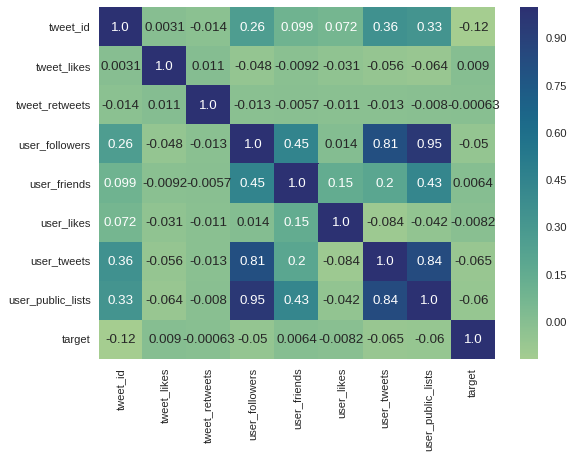

In [313]:
# Correlation heatmap of numeric features and response -
# No strong correlations are observed
sns.heatmap(train.corr(), annot=True, fmt='.2', cmap='crest')

In [268]:
# Check proportions of target values for each user tweets
user = train.groupby('name').target.value_counts(normalize=True).to_frame(name='value')
user = user.reset_index().pivot(index='name', columns='target', values='value')
user

target,0.00,1.00,2.00
name,,,
#DancingAU,0.31,0.51,0.17
60 Minutes Australia,0.38,0.21,0.42
7AFL,0.28,0.45,0.27
7Cricket,0.30,0.28,0.42
7HorseRacing ð,0.33,0.32,0.35
7NEWS Australia,0.34,0.44,0.23
9News Australia,0.39,0.43,0.18
A Current Affair,0.33,0.28,0.40
Allison Langdon,0.62,nan,0.38


In [269]:
# Some users don't have any tweets with certain targets
# e.g. AustraliaGotTalent only has target values of 1
# Add on total tweets to check the volumes
total_tweets = train.groupby('name').size().to_frame(name='Total_Tweets').reset_index()

pd.merge(user, total_tweets, on='name')

,name,0.0,1.0,2.0,Total_Tweets
0,#DancingAU,0.31,0.51,0.17,272
1,60 Minutes Australia,0.38,0.21,0.42,1946
2,7AFL,0.28,0.45,0.27,2376
3,7Cricket,0.30,0.28,0.42,3208
4,7HorseRacing ð,0.33,0.32,0.35,2793
5,7NEWS Australia,0.34,0.44,0.23,1934
6,9News Australia,0.39,0.43,0.18,1535
7,A Current Affair,0.33,0.28,0.40,1915
8,Allison Langdon,0.62,nan,0.38,8
9,Amazing Grace,0.36,0.03,0.61,92


A number of users have higher weighting of observations in a specific bucket. For example, 50% of 'The Block' 1,054 tweets have a response of a stock price increase. Similarly, 54% of SAS Australia on 7's 577 tweets also have a 'Increase' response. This may mean that 'user' can potentially be a strong predictor in our model.

We can also see that the users with no values in some targets have low tweets in total.

In [314]:
# Add K-means cluster to training data
train = pd.merge(train, words_df['KM_Cluster'], left_index=True, right_index=True)

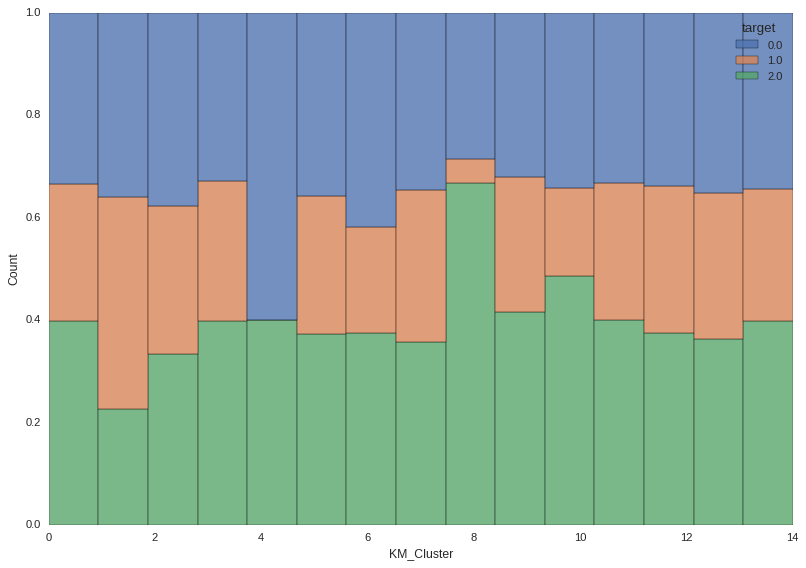

In [316]:
# Check proportions of target values for each KM clusters
km = train.groupby('KM_Cluster').target.value_counts(normalize=True).to_frame(name='value')
km = km.reset_index()
# Visualise proportions
plt.figure(figsize=(12,8))
sns.histplot(x='KM_Cluster', weights='value', data=km, hue='target', multiple='stack', bins=15,
             palette='deep')

In [318]:
# Check volumes in clusters
train.KM_Cluster.value_counts()

3     19671
9      3147
5      2518
1      2425
12     2303
0      2183
7      1666
13     1634
11     1578
14     1448
10     1159
2       769
6       291
8        21
4         5
Name: KM_Cluster, dtype: int64

A number of clusters have different proportions of responses, for example, Cluster 1 has only 20% 'Increase' responses and Cluster 10 has about 50% 'Increases'. Hence, it may be worthwhile adding the K-means cluster to our model.

In addition to our text features (TF-IDF or PCA transformed word vectors), we can use 'name', 'tweet_likes' and 'tweet_retweets' as additional features for our model. 

Metrics about users such as user-followers, friends, likes, tweets etc. should be captured in the 'name' feature as these metrics are generally static at point of extract. Hence, only using 'name' to represent the user should suffice.

In [299]:
# check that name to user_followers is one-to-one
train.groupby('name').user_followers.value_counts()

name                      user_followers
#DancingAU                12945              272
60 Minutes Australia      173795            1946
7AFL                      80588             2176
                          80587              200
7Cricket                  83332             2608
                          83340              600
7HorseRacing ð         20623             2195
                          20624              598
7NEWS Australia           199023            1334
                          199029             600
9News Australia           639595            1535
A Current Affair          62248             1915
Allison Langdon           25009                8
Amazing Grace             64                  92
Australia's Got Talent    21074                2
Australian Ninja Warrior  3427               474
Big Brother Australia     915                 28
Brian Taylor              47577               36
Carols by Candlelight     157                  4
Carrie Bickmore           26

## b. Neural network

### Data preparation

Before building our neural network, we need to prepare our features as suitable inputs. We start with vectorising features, such as 'name' of Twitter user and the K-means cluster, which are categorical features, and also scaling our numeric features, such as 'tweet_likes'.

In [12]:
# Split out target variable
train_labels = train['target']
train.drop('target', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
train.columns

Index(['username', 'name', 'tweet_id', 'tweet_post_time', 'tweet_text',
       'tweet_likes', 'tweet_retweets', 'user_followers', 'user_friends',
       'user_likes', 'user_tweets', 'user_public_lists', 'user_start_date',
       'retweet', 'TweetHour', 'TweetDay', 'Hour', '_merge', 'month'],
      dtype='object')

In [ ]:
# Split features for transformation
# add retweet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_features = ['name', 'KM_Cluster'] # categorical features to one-hot encode
num_features = ['tweet_likes', 'tweet_retweets'] # numerical features to scale

pipeline = ColumnTransformer([
    ('one_hot', OneHotEncoder(), cat_features),
    ('num_scale', StandardScaler(), num_features)                     
])

# Fit features on training data and transform
train_prep = pipeline.fit_transform(train)

In [286]:
pipeline.transformers_

[('one_hot',
  OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=True),
  ['name', 'KM_Cluster']),
 ('num_scale',
  StandardScaler(copy=True, with_mean=True, with_std=True),
  ['tweet_likes', 'tweet_retweets']),
 ('remainder',
  'drop',
  [0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])]

In [288]:
# Expected shape
print('Expected dim of processed data: ({}, {})\n Actual dim of processed data: {}'\
      .format(len(train), train.name.nunique() + train.KM_Cluster.nunique() + 2, 
              train_prep.get_shape()))

# no. features = no. levels in categorical features plus tweet_likes and tweet_retweets

Expected dim of processed data: (40818, 67)
 Actual dim of processed data: (40818, 67)


In [289]:
train_prep

<40818x67 sparse matrix of type '<class 'numpy.float64'>'
	with 163272 stored elements in Compressed Sparse Row format>

In [292]:
# # Join word features to training data
# from scipy.sparse import hstack
# # Concatenate by rows of tweets and convert to CSR format for slicing
# train_prep = hstack((train_prep, pca_out[train.index])).tocsr()
# train_prep.get_shape()

(40818, 458)

Using TF-IDF vectors vs PCA transformed vectors:
+ Extra variance may add that extra information to differentiate different response buckets
+ Neural network described as being able to perform dimension reduction thru its architecture

- Higher dimension features can cause less stable training due to the additional weights that are required to train.

In [327]:
# Join word features to training data
from scipy.sparse import hstack
# Concatenate by rows of tweets and convert to CSR format for slicing
train_prep = hstack((train_prep, tfidf_out[train.index])).tocsr()
train_prep.get_shape()

(40818, 657)

In [298]:
## Store names of features
# Get names of categorical features from one-hot-encoder
feat_cols = list(pipeline.transformers_[0][1].get_feature_names())
# Add numeric features
feat_cols += ['tweet_likes', 'tweet_retweets']
# Add text features
feat_cols += tfidf.get_feature_names()

In [328]:
# save prepared training features and labels
# pickle.dump(train_prep, open('train_prep_PC_210921.pkl', 'wb'))
# pickle.dump(train_labels, open('train_labels.pkl', 'wb'))

In [5]:
# load prepared training features from last save
import pickle
train_prep = pickle.load(open('train_prep_TF_210921.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))

In [6]:
# Hold out 10% of training data for validation
val_ind = round(train_prep.shape[0] * 0.9)

print('Number of training instances:', train_prep.shape[0])
X_train = train_prep[:val_ind]
X_val = train_prep[val_ind:]

# Check split - looks good!
print('Train/val split:')
print(X_train.shape[0])
print(X_val.shape[0])
print('{:.4%}'.format(X_train.shape[0] / train_prep.shape[0]))
print('{:.4%}'.format(X_val.shape[0] / train_prep.shape[0]))

# Separate training features and labels
y_train = train_labels[:val_ind]
y_val = train_labels[val_ind:]
print('Check labels split:')
print(len(y_train))
print(len(y_val))

Number of training instances: 40818
Train/val split:
36736
4082
89.9995%
10.0005%
Check labels split:
36736
4082


### Model building

To start building our neural network - we need to make decisions around the architecture by answering questions such as:
* What loss function do we optimise?
* What is our output activation function?
* How many hidden layers and units in each layer? 
* What activation functions do we use at each layer?
* What optimiser do we use?
* What learning rate do we use?
* How many epochs to train for?
* What batch size do we use to feed our data into the model?
* What metrics do we want to capture in training?
* How do we incorporate regularisation in our model?

Our choices will depend on factors such as:
* The nature of the problem we are trying to solve - do tweets carry predictive power for stock prices?
* What neural network architecture best represents our data and captures linear and non-linear patterns between our features and response?
* What is the nature of created loss function that we are trying to minimise?

To begin with, we will start with 1 hidden layer and aim to improve upon it.

#### Baseline

In [7]:
from keras.utils.np_utils import to_categorical

# Convert to one-hot encoding for keras
one_hot_y_train = to_categorical(y_train)
one_hot_y_val = to_categorical(y_val)

# check - a classifer that predicts all values as increases (3rd class) will have
# 38% accuracy. We need to beat this classifier as a baseline.
print(one_hot_y_train.sum(axis=0))
print(one_hot_y_val.sum(axis=0))
print(train_labels.value_counts(normalize=True))

[12356. 10445. 13935.]
[1399.  909. 1774.]
2.0    0.384855
0.0    0.336984
1.0    0.278162
Name: target, dtype: float64


We can consider a naive baseline model as a classifier that all cases as price increases, which is the majority class in the response variable in our training set. From the above statistics, the model will have 38% accuracy on our training set. Hence, any model that we build needs to significantly exceed this 38% baseline for us to be confident in our model's performance.

Our features that we will use to build our model are
* TF-IDF word vectors
* One-hot encoded 'name' and K-means cluster features
* Scaled 'tweet_likes' and 'tweet_retweets'

In further model improvements, we experiment with different feature sets. However, we first must build a working model.

In [8]:
# Keep a log of first iteration of neural network
model_log = {}

# Log initial architecture selection for first neural network
model_log['Model_0'] = {'Optimiser': 'SGD',
                        'Batch_size': X_train.shape[0],
                        'Learning_rate': 0.01, # default for SGD in Keras
                        'Epochs': 50,
                        'Layers': 1,
                        'Units': [8],
                        'Activation': ['relu'],
                        'Regularisation': None}

In [9]:
from keras import models, layers
from numpy.random import seed
from tensorflow.random import set_seed

# Set seed for reproducibility
seed(12)
set_seed(34)

# Initiate neural network
model = models.Sequential()
# Add 1 hidden layer, with 8 units and relu activation function - commonly used
# as it's generally quite effective at adding non-linearities to the network
model.add(layers.Dense(8, activation = 'relu', input_shape = (X_train.shape[1],)))
# Add output layer with Softmax activation for 3 class classification
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer='SGD', # Stochastic gradient descent optimisation
              loss = 'categorical_crossentropy', # default loss function for multi-class classification
              metrics = ['accuracy']) # Monitor training accuracy over epochs

history = model.fit(X_train, one_hot_y_train, # training features and labels
                    validation_data = (X_val, one_hot_y_val), # validation data - estimate generalisation error
                    epochs = 50, # pass through data 50 times
                    batch_size = X_train.shape[0] # data is fed in as an entire batch
                   )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1/1 [==============================] - 1s 1s/step - loss: 1.1074 - accuracy: 0.3005 - val_loss: 1.1147 - val_accuracy: 0.2406
Epoch 2/50
1/1 [==============================] - 0s 237ms/step - loss: 1.1073 - accuracy: 0.3018 - val_loss: 1.1145 - val_accuracy: 0.2420
Epoch 3/50
1/1 [==============================] - 0s 234ms/step - loss: 1.1071 - accuracy: 0.3026 - val_loss: 1.1142 - val_accuracy: 0.2423
Epoch 4/50
1/1 [==============================] - 0s 221ms/step - loss: 1.1070 - accuracy: 0.3034 - val_loss: 1.1140 - val_accuracy: 0.2435
Epoch 5/50
1/1 [==============================] - 0s 224ms/step - loss: 1.1068 - accuracy: 0.3032 - val_loss: 1.1137 - val_accuracy: 0.2445
Epoch 6/50
1/1 [==============================] - 0s 229ms/step - loss: 1.1067 - accuracy: 0.3033 - val_loss: 1.1135 - val_accuracy: 0.2460
Epoch 7/50
1/1 [==============================] - 0s 234ms/step - loss: 1.1066 - accuracy: 0.3044 - val_loss: 1.1132 - val_accuracy: 0.2457
Epoch 8/50
1/1 [==================

In [10]:
# Plot training vs validation loss
import matplotlib.pyplot as plt
def plot_training_history(history):
  epochs = range(1, len(history.history['loss']) + 1)

  fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12,6))
  # Plot training vs validation loss
  ax[0].plot(epochs, history.history['loss'], 'go', label = 'Training loss')
  ax[0].plot(epochs, history.history['val_loss'], 'r', label = 'Validation loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  # Plot training vs validation accuracy
  ax[1].plot(epochs, history.history['accuracy'], 'go', label = 'Training accuracy')
  ax[1].plot(epochs, history.history['val_accuracy'], 'r', label = 'Validation accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

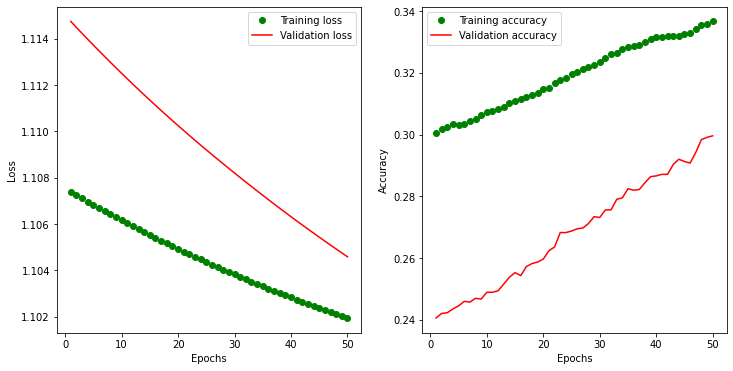

In [11]:
# View training history
plot_training_history(history)

In [12]:
# Add final training, validation loss and accuracy to log
model_log['Model_0']['Metrics'] = {metric: val[-1] for metric, val in history.history.items()}
# View log
model_log['Model_0']

{'Activation': ['relu'],
 'Batch_size': 36736,
 'Epochs': 50,
 'Layers': 1,
 'Learning_rate': 0.01,
 'Metrics': {'accuracy': 0.33667248487472534,
  'loss': 1.1019513607025146,
  'val_accuracy': 0.2996080219745636,
  'val_loss': 1.1045900583267212},
 'Optimiser': 'SGD',
 'Regularisation': None,
 'Units': [8]}

From our initial model's performance, it looks like the model is overfitting the training set as the training loss is consistently lower than the validation loss. However, the training accuracy is also quite poor, reaching 33.7%, which is even less than a classifier that classifies all observations as price increases (38% accuracy).

Hence, our next steps are to improve the learning capacity of the model to perform better on the training set, and then cut back on the overfitting.

We have made decisions around the architecture that likely won't be changed:
* What loss function do we optimise? 

Categorical crossentropy is the best loss function for multi-class classification, as it measures the distance between the probability distributions estimated by the trained network, and the true distribution of the labels. By minimising this quantity, our predicted labels should be as close as possible to the actual labels.
* What is our output activation function?

Softmax as it produces a probability of an observation belonging to each of the three classes in our labels. 

The following questions remain for us to change and optimise:
* How many hidden layers and units in each layer? 
* What activation functions do we use at each layer?
* What optimiser do we use?
* What learning rate do we use?
* How many epochs to train for?
* What batch size do we use?
* What metrics do we want to capture in training?
* How do we incorporate regularisation in our model?

#### i. Change optimiser, batch size, learning rate

In [13]:
# Log the NN hyperparameters in our 2nd iteration
model_log['Model_1'] = {'Optimiser': 'Adam', # Try Adam instead of SGD
                        'Batch_size': 512, # Reduce the batch size
                        'Learning_rate': 0.001, # default for Adam in Keras
                        'Epochs': 50,
                        'Layers': 1,
                        'Units': [8],
                        'Activation': ['relu'],
                        'Regularisation': None}

We have changed three components in our architecture.
1. Using the Adam optimiser instead of the vanilla Stochastic Gradient Descent. The momentum feature of the optimiser has been shown to be able to improve training. 
2. Using a smaller batch size of 512 samples instead of the whole batch of training data. Smaller batch sizes can speed up training times and improve generalisation of the model.
3. The default learning rate of the Adam optimiser is lower at 0.001. A lower learning rate trains slower as it makes smaller weight changes at each step. 

We will need to observe the effect of the mentioned changes on the training and validation performance of our model, to verify whether they are an improvement or not. 

In [14]:
# Set seed for reproducibility
seed(12)
set_seed(34)

# Initiate neural network
model = models.Sequential()
# Maintain same hidden layer and units
model.add(layers.Dense(8, activation = 'relu', input_shape = (X_train.shape[1],)))
# Same output layer
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer='Adam', # Try Adam optimisation which improves upon the SGD
              loss = 'categorical_crossentropy', # same loss function
              metrics = ['accuracy']) # Continue to monitor training accuracy 

history = model.fit(X_train, one_hot_y_train, # training features and labels
                    validation_data = (X_val, one_hot_y_val), # validation data - estimate generalisation error
                    epochs = 50, # pass through data 50 times
                    batch_size = 512 # try a smaller batch size
                   )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_2/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_2/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_2/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


72/72 [==============================] - 1s 6ms/step - loss: 1.0957 - accuracy: 0.3571 - val_loss: 1.0858 - val_accuracy: 0.4199
Epoch 2/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0797 - accuracy: 0.3991 - val_loss: 1.0772 - val_accuracy: 0.4245
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0660 - accuracy: 0.4237 - val_loss: 1.0757 - val_accuracy: 0.4145
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0561 - accuracy: 0.4358 - val_loss: 1.0747 - val_accuracy: 0.3866
Epoch 5/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0494 - accuracy: 0.4444 - val_loss: 1.0747 - val_accuracy: 0.3770
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0441 - accuracy: 0.4490 - val_loss: 1.0799 - val_accuracy: 0.3665
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0402 - accuracy: 0.4565 - val_loss: 1.0805 - val_accuracy: 0.3667
Epoch 8/50
72/72 [=============

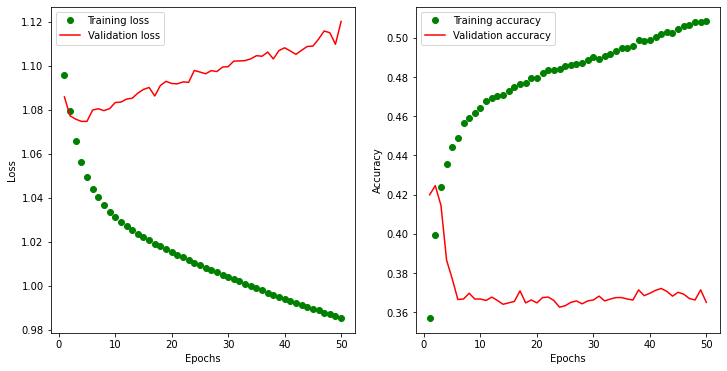

In [15]:
# View training history
plot_training_history(history)

In [16]:
# Add final training, validation loss and accuracy to log
model_log['Model_1']['Metrics'] = {metric: val[-1] for metric, val in history.history.items()}
# View log
model_log['Model_1']

{'Activation': ['relu'],
 'Batch_size': 512,
 'Epochs': 50,
 'Layers': 1,
 'Learning_rate': 0.001,
 'Metrics': {'accuracy': 0.5083025097846985,
  'loss': 0.9853881597518921,
  'val_accuracy': 0.3650171458721161,
  'val_loss': 1.1201250553131104},
 'Optimiser': 'Adam',
 'Regularisation': None,
 'Units': [8]}

By changing our optimiser to Adam, and using a lower learning rate of 0.001 and smaller batch size of 512, our model's performance has already improved. The training accuracy has reached 50.8%, significantly higher than before, and the validation accuracy peaks at 42% before plateauing around 37%. With the greater training performance, we also have much greater overfitting on our training data, which is shown in the disparity between the training and validation losses. Particularly, the training loss continues to reduce while the validation loss actually increases over the epochs.

#### ii. Regularisation - L2, Dropout
Hence, our next step is to focus on reducing overfitting by regularising our model. There are a number of regularisation techniques which include:
* L1/L2 weight regularisation - reduces the size of the weights in the hidden layers by adding a penalty term for large weights. For L1, the penalty is added proportional to the absolute value of the weights. For L2, the penalty is added proportional to the square of the value of weights.
* Dropout layer - a proportion of output nodes are 'dropped' at random by setting their values to zero.

In [17]:
# Log the NN hyperparameters in our 2nd iteration
model_log['Model_2'] = {'Optimiser': 'Adam',
                        'Batch_size': 512,
                        'Learning_rate': 0.001, 
                        'Epochs': 50,
                        'Layers': 1,
                        'Units': [8],
                        'Activation': ['relu'],
                        'l2': 0.01, # add regularisation in the form of l2 reg
                        'Dropout': 0.375} # add dropout layer at rate 0.375

In [57]:
from keras.regularizers import l2

# Set seed for reproducibility
seed(12)
set_seed(34)

# Initiate neural network
model = models.Sequential()
# Maintain same hidden layer and units
model.add(layers.Dense(8, activation = 'relu', input_shape = (X_train.shape[1],),
                       kernel_regularizer=l2(0.01))) # Add l2 regularisation with a penalty parameter of 1%
# Add a dropout layer that randomly drops 37.5% or 3 out of 8 input units in the hidden layer
model.add(layers.Dropout(0.375))
# Same output layer
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer='Adam', # Keep Adam optimisation
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']) 

# Train model with same epochs and batch size as before
history = model.fit(X_train, one_hot_y_train,
                    validation_data = (X_val, one_hot_y_val),
                    epochs = 50, 
                    batch_size = 512 
                   )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_38/dense_82/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_38/dense_82/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_38/dense_82/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


72/72 [==============================] - 1s 6ms/step - loss: 1.4479 - accuracy: 0.3545 - val_loss: 1.1762 - val_accuracy: 0.4343
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 1.2011 - accuracy: 0.3799 - val_loss: 1.1345 - val_accuracy: 0.4348
Epoch 3/50
72/72 [==============================] - 0s 5ms/step - loss: 1.1534 - accuracy: 0.3862 - val_loss: 1.1106 - val_accuracy: 0.4346
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 1.1213 - accuracy: 0.3901 - val_loss: 1.0966 - val_accuracy: 0.4343
Epoch 5/50
72/72 [==============================] - 0s 5ms/step - loss: 1.1056 - accuracy: 0.3935 - val_loss: 1.0887 - val_accuracy: 0.4346
Epoch 6/50
72/72 [==============================] - 0s 5ms/step - loss: 1.0958 - accuracy: 0.3999 - val_loss: 1.0860 - val_accuracy: 0.4346
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0856 - accuracy: 0.4083 - val_loss: 1.0835 - val_accuracy: 0.4343
Epoch 8/50
72/72 [=============

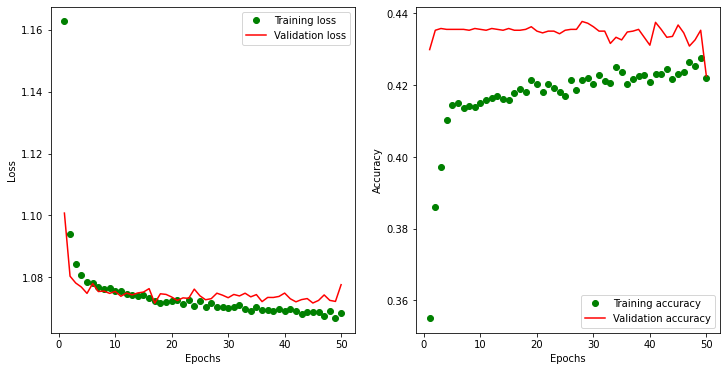

In [19]:
# View training history
plot_training_history(history)

In [20]:
# Add final training, validation loss and accuracy to log
model_log['Model_2']['Metrics'] = {metric: val[-1] for metric, val in history.history.items()}
# View log
model_log['Model_2']

{'Activation': ['relu'],
 'Batch_size': 512,
 'Dropout': 0.375,
 'Epochs': 50,
 'Layers': 1,
 'Learning_rate': 0.001,
 'Metrics': {'accuracy': 0.4220111072063446,
  'loss': 1.0683637857437134,
  'val_accuracy': 0.42258697748184204,
  'val_loss': 1.0776094198226929},
 'Optimiser': 'Adam',
 'Units': [8],
 'l2': 0.01}

By adding L2 regularisation and dropout, we have significantly reduced overfitting as our validation and training losses are much closer in value. However, the training accuracy is consistently lower than the validation accuracy for most of the epochs, which suggests that we may have inhibited the learning capacity of our model. In addition, our validation accuracy has improved significantly from our initial model (from 30% to 42%), however, the model's performance is arguably not significantly better than our naive baseline (38% accuracy from classifying all cases as increases).



#### iii. Batch Normalisation
Our next steps will be to increase the model's capacity to learn by adding more layers and units. Another type of layer that we can add is the `BatchNormalization` layer, which can speed up training convergence, has regularisation effects and can stabilise training results. It does this by normalisation (re-centreing and re-scaling) of the inputs.

In [62]:
# Log the NN hyperparameters in our 3rd iteration
model_log['Model_3'] = {'Optimiser': 'Adam',
                        'Batch_size': 512,
                        'Learning_rate': 0.001, # default for Adam in Keras
                        'Epochs': 50,
                        'Layers': 1,
                        'Units': [8],
                        'Activation': ['relu'],
                        'l2': 0.01,
                        'Dropout': 0.375,
                        'BatchNorm': True}

In [66]:
from keras.regularizers import l2

# Set seed for reproducibility
seed(12)
set_seed(34)

# Initiate neural network
model = models.Sequential()
# Maintain same hidden layer, units and l2 regularisation
model.add(layers.Dense(8, activation = 'relu', input_shape = (X_train.shape[1],),
                       kernel_regularizer=l2(0.01)))
# Add Batch Normalization to improve performance
model.add(layers.BatchNormalization())                       
# Keep dropout
model.add(layers.Dropout(0.375))
# Same output layer
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer='Adam', # Keep Adam optimisation
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']) 

# Train model with same epochs and batch size as before
history = model.fit(X_train, one_hot_y_train,
                    validation_data = (X_val, one_hot_y_val),
                    epochs = 50, 
                    batch_size = 512 
                   )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_40/dense_86/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_40/dense_86/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_40/dense_86/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


72/72 [==============================] - 1s 7ms/step - loss: 1.4822 - accuracy: 0.3529 - val_loss: 1.1822 - val_accuracy: 0.4351
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 1.2134 - accuracy: 0.3788 - val_loss: 1.1405 - val_accuracy: 0.4346
Epoch 3/50
72/72 [==============================] - 0s 5ms/step - loss: 1.1588 - accuracy: 0.3828 - val_loss: 1.1154 - val_accuracy: 0.4346
Epoch 4/50
72/72 [==============================] - 0s 5ms/step - loss: 1.1331 - accuracy: 0.3857 - val_loss: 1.0998 - val_accuracy: 0.4346
Epoch 5/50
72/72 [==============================] - 0s 5ms/step - loss: 1.1129 - accuracy: 0.3888 - val_loss: 1.0907 - val_accuracy: 0.4346
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: 1.1005 - accuracy: 0.3891 - val_loss: 1.0868 - val_accuracy: 0.4346
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0949 - accuracy: 0.3922 - val_loss: 1.0839 - val_accuracy: 0.4351
Epoch 8/50
72/72 [=============

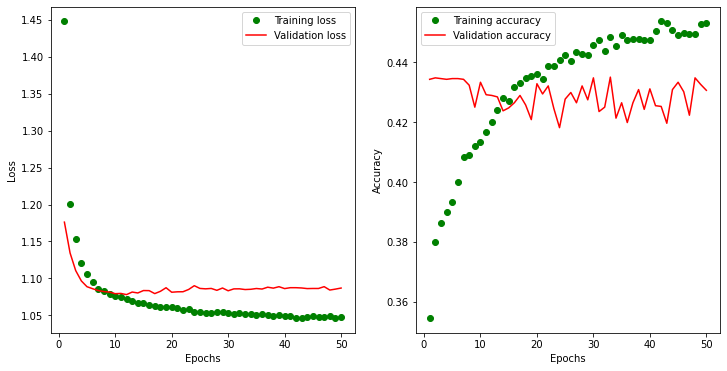

In [60]:
# View training history
plot_training_history(history)

In [63]:
# Add final training, validation loss and accuracy to log
model_log['Model_3']['Metrics'] = {metric: val[-1] for metric, val in history.history.items()}
# View log
model_log['Model_3']

{'Activation': ['relu'],
 'BatchNorm': True,
 'Batch_size': 512,
 'Dropout': 0.375,
 'Epochs': 50,
 'Layers': 1,
 'Learning_rate': 0.001,
 'Metrics': {'accuracy': 0.4532066583633423,
  'loss': 1.0471855401992798,
  'val_accuracy': 0.43067124485969543,
  'val_loss': 1.0869433879852295},
 'Optimiser': 'Adam',
 'Units': [8],
 'l2': 0.01}

From adding Batch Normalisation, the model appears to train a lot faster with the training loss dipping below the validation loss at around 8 epochs and no longer plateauing. The validation accuracy appears to be quite volatile which could be due to the additional parameters from Batch Normalisation that are also being updated with each epoch.

From the above validation loss and accuracy curves, there is a noticeable plateau from around epoch 5 where there is no longer any improvement in performance on the validation set. Hence, to obtain the same level of validation performance, the model can be trained for only 5 epochs as opposed to 50 epochs.

To reduce training times and optimise generalisation, the subsequent models will use the `EarlyStopping` callback from Keras. This callback monitors the validation loss across epochs and stops training if there is no significant improvement for a set number of epochs.

In [23]:
# Set early stopping - model stops training once loss function is barely improving
# Prevents model from training for many epochs without improvement on validation set
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', # monitor val loss as stopping criteria
                          verbose=1,
                          patience=5, # set to monitor 5 epochs before stopping
                          restore_best_weights=True) # return weights of best epoch, rather than last

#### iv. Change layers and units

We have yet to experiment with different layers and units from our initial single layer of 8 units, which has been improved upon quite well. To start with, we will first vary the number of units in the single hidden layer from 4 to 12 in steps of 2 units. There most likely will be interaction between the number of units and other hyperparameters, such as the learning rate and L2 penalty rate, however, to keep it simple we will only vary the number of units and use the hyperparameters from our previous architecture.

We will further tune the hyperparameters at a later stage.

In [53]:
# Create function to build model at each iteration
def build_model(hidden_units):
  # Initiate neural network
  model = models.Sequential()
  # Adjust the number of units in the layer
  model.add(layers.Dense(hidden_units, activation = 'relu', input_shape = (X_train.shape[1],),
                        kernel_regularizer=l2(0.01))) 
  # Keep Batch Normalisation and Dropout
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.375))
  # Output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  # Use Adam optimiser and loss for multiclass classification
  model.compile(optimizer='Adam',
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
  return model

In [54]:
# Set seed for reproducibility
seed(12)
set_seed(34)

results = {}

for i in [4, 6, 8, 10, 12]:
  model = build_model(hidden_units = i)

  # Train model with same epochs and batch size as before
  history = model.fit(X_train, one_hot_y_train,
                      validation_data = (X_val, one_hot_y_val),
                      verbose=0,
                      epochs = 50, 
                      batch_size = 512,
                      callbacks = [earlystop] # use early stopping
                    )
  # Save results of training metrics and number of training epochs
  results['Units_' + str(i)] = {metric: val[-1] for metric, val in history.history.items()}
  results['Units_' + str(i)]['epochs'] = len(history.history['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_32/dense_71/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_32/dense_71/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_32/dense_71/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_33/dense_73/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_33/dense_73/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_33/dense_73/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_34/dense_75/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_34/dense_75/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_34/dense_75/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_35/dense_77/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_35/dense_77/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_35/dense_77/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_36/dense_79/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_36/dense_79/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_36/dense_79/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping


In [55]:
# View training results
pd.DataFrame(results)

,Units_4,Units_6,Units_8,Units_10,Units_12
loss,1.066080,1.071023,1.062242,1.057589,1.055733
accuracy,0.416894,0.435921,0.434860,0.440685,0.447953
val_loss,1.075051,1.077607,1.078160,1.093021,1.084638
val_accuracy,0.426017,0.434346,0.427976,0.436061,0.429446
epochs,22.000000,17.000000,14.000000,14.000000,15.000000


From our training results, using 6 units and 10 units provides an improvement in both training and validation accuracy over 8 units. However, it is interesting to note that the validation loss for 10 units is higher than that for 8 units. 

We will experiment with adding a 2nd layer to our network with varying hidden units. We will use the same activation function 'relu' and regularisation as the first layer to get a quick grasp of any potential improvements for the model. 

In [68]:
def build_model(hidden_units_1, hidden_units_2):
  # Initiate neural network
  model = models.Sequential()
  # Adjust the number of units in the first layer
  model.add(layers.Dense(hidden_units_1, activation = 'relu', input_shape = (X_train.shape[1],),
                        kernel_regularizer=l2(0.01))) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.375))
  # Add second layer with adjustable units
  model.add(layers.Dense(hidden_units_2, activation = 'relu', kernel_regularizer=l2(0.01))) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.375))
  # Output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  # Use Adam optimiser and loss for multiclass classification
  model.compile(optimizer='Adam',
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
  return model

In [69]:
# Set seed for reproducibility
seed(12)
set_seed(34)

results = {}

for i in [4, 6, 8, 10, 12]:
  for j in [4, 6, 8, 10, 12]:
    model = build_model(hidden_units_1 = i, hidden_units_2 = j)

    # Train model with same epochs and batch size as before
    history = model.fit(X_train, one_hot_y_train,
                        validation_data = (X_val, one_hot_y_val),
                        verbose=0,
                        epochs = 50, 
                        batch_size = 512,
                        callbacks = [earlystop] # use early stopping
                      )
    # Save results of training metrics and number of training epochs
    model_ver = 'Layer1_' + str(i) + '_Layer2_' + str(j)
    results[model_ver] = {metric: val[-1] for metric, val in history.history.items()}
    results[model_ver]['epochs'] = len(history.history['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_41/dense_88/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_41/dense_88/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_41/dense_88/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_42/dense_91/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_42/dense_91/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_42/dense_91/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_43/dense_94/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_43/dense_94/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_43/dense_94/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_44/dense_97/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_44/dense_97/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_44/dense_97/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_45/dense_100/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_45/dense_100/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_45/dense_100/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_46/dense_103/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_46/dense_103/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_46/dense_103/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_47/dense_106/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_47/dense_106/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_47/dense_106/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_48/dense_109/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_48/dense_109/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_48/dense_109/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_49/dense_112/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_49/dense_112/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_49/dense_112/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_50/dense_115/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_50/dense_115/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_50/dense_115/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_51/dense_118/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_51/dense_118/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_51/dense_118/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_52/dense_121/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_52/dense_121/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_52/dense_121/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_53/dense_124/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_53/dense_124/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_53/dense_124/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_54/dense_127/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_54/dense_127/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_54/dense_127/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_55/dense_130/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_55/dense_130/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_55/dense_130/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_56/dense_133/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_56/dense_133/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_56/dense_133/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_57/dense_136/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_57/dense_136/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_57/dense_136/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_58/dense_139/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_58/dense_139/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_58/dense_139/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_59/dense_142/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_59/dense_142/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_59/dense_142/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_60/dense_145/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_60/dense_145/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_60/dense_145/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_61/dense_148/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_61/dense_148/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_61/dense_148/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_62/dense_151/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_62/dense_151/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_62/dense_151/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_63/dense_154/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_63/dense_154/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_63/dense_154/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_64/dense_157/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_64/dense_157/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_64/dense_157/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_65/dense_160/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_65/dense_160/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_65/dense_160/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping


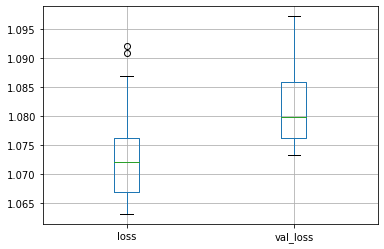

In [76]:
# Visualise distribution of training and validation losses
pd.DataFrame(results).transpose().iloc[:, [0, 2]].boxplot()

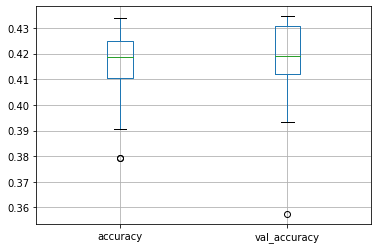

In [77]:
# Visualise distribution of training and validation accuracy
pd.DataFrame(results).transpose().iloc[:, [1, 3]].boxplot()

From looking at a boxplot of the training metrics across the 25 model iterations, there is not a significant variation in the training metrics. The Inter-quartile range shows that 50% of iterations have training and validation loss within a 0.01 range. Training accuracy is within about 1.5% and validation accuracy is within almost a 2% range. The median accuracy and validation accuracy across the model iterations is also virtually equal. From the plots, there are a few outlying models that can be identified.

In [84]:
# Look at the 5 iterations with the highest validation accuracy
pd.DataFrame(results).transpose().sort_values('val_accuracy', ascending=False)[:5]

,loss,accuracy,val_loss,val_accuracy,epochs
Layer1_4_Layer2_4,1.086488,0.390571,1.073882,0.434591,26.0
Layer1_8_Layer2_4,1.091957,0.379328,1.074793,0.434591,44.0
Layer1_4_Layer2_10,1.086922,0.393783,1.074227,0.434591,32.0
Layer1_4_Layer2_12,1.090857,0.379165,1.089269,0.434591,16.0
Layer1_12_Layer2_4,1.073279,0.418690,1.077642,0.434591,30.0


In [86]:
# Look at the 5 iterations with the lowest validation loss
pd.DataFrame(results).transpose().sort_values('val_loss', ascending=True)[:5]

,loss,accuracy,val_loss,val_accuracy,epochs
Layer1_6_Layer2_10,1.073795,0.408210,1.073213,0.422097,33.0
Layer1_4_Layer2_4,1.086488,0.390571,1.073882,0.434591,26.0
Layer1_12_Layer2_6,1.069982,0.421058,1.073899,0.430671,29.0
Layer1_4_Layer2_10,1.086922,0.393783,1.074227,0.434591,32.0
Layer1_8_Layer2_4,1.091957,0.379328,1.074793,0.434591,44.0


In [211]:
# Compare with previous model with single hidden layer
model_log['Model_3']['Metrics']

{'accuracy': 0.4532066583633423,
 'loss': 1.0471855401992798,
 'val_accuracy': 0.43067124485969543,
 'val_loss': 1.0869433879852295}

We can see that the models with the highest validation accuracy all have the same score but different validation losses. This could be due to the nature of the cases in our validation set. These models also have relatively low training accuracy, which is a sign of the model underfitting. This leads to the danger of 'overfitting' on the validation set, where we rely too much on the validation performance which is also subject to sampling error and we are overreacting to the noise in the validation set. 

Hence, we will select a model from our iterations by looking at both the training and validation performance. From looking at the 5 iterations with the lowest validation loss, we can identify that a suitable model in the iteration with 12 units in the 1st layer and 6 layers in the 2nd layer, which has a training accuracy of 42% and validation accuracy of 43%. The training loss is also slightly lower than the validation loss. This model looks suitable as it has relatively high performance on both the training and validation sets, and does not show signs of underfitting nor overfitting.


In [89]:
# Log the architecture settings for updated model
model_log['Model_4'] = {'Optimiser': 'Adam',
                        'Batch_size': 512,
                        'Learning_rate': 0.001, # default for Adam in Keras
                        'Epochs': 50,
                        'Layers': 2,
                        'Units': [12, 6],
                        'Activation': ['relu'],
                        'l2': 0.01,
                        'Dropout': 0.375,
                        'BatchNorm': True}

In [116]:
### Fit selected model once again
# Set seed for reproducibility
seed(12)
set_seed(34)

# Initiate neural network
model = models.Sequential()
# Create first layer with 12 units
model.add(layers.Dense(12, activation = 'relu', input_shape = (X_train.shape[1],),
                      kernel_regularizer=l2(0.01))) 
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.375))
# Create 2nd layer with 6 units
model.add(layers.Dense(6, activation = 'relu', kernel_regularizer=l2(0.01))) 
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.375))
# Output layer
model.add(layers.Dense(3, activation = 'softmax'))

# Use Adam optimiser and loss for multiclass classification
model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Train model with same epochs and batch size as before
history = model.fit(X_train, one_hot_y_train,
                    validation_data = (X_val, one_hot_y_val),
                    epochs = 10, # found from early stopping
                    batch_size = 512,
                    callbacks = [earlystop]
                  )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_71/dense_178/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_71/dense_178/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_71/dense_178/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


72/72 [==============================] - 1s 8ms/step - loss: 1.6542 - accuracy: 0.3432 - val_loss: 1.3043 - val_accuracy: 0.4346
Epoch 2/10
72/72 [==============================] - 0s 5ms/step - loss: 1.4249 - accuracy: 0.3645 - val_loss: 1.2367 - val_accuracy: 0.4346
Epoch 3/10
72/72 [==============================] - 0s 5ms/step - loss: 1.3071 - accuracy: 0.3784 - val_loss: 1.1897 - val_accuracy: 0.4346
Epoch 4/10
72/72 [==============================] - 0s 5ms/step - loss: 1.2433 - accuracy: 0.3884 - val_loss: 1.1587 - val_accuracy: 0.4346
Epoch 5/10
72/72 [==============================] - 0s 5ms/step - loss: 1.1956 - accuracy: 0.3907 - val_loss: 1.1382 - val_accuracy: 0.4346
Epoch 6/10
72/72 [==============================] - 0s 5ms/step - loss: 1.1643 - accuracy: 0.4008 - val_loss: 1.1256 - val_accuracy: 0.4346
Epoch 7/10
72/72 [==============================] - 0s 5ms/step - loss: 1.1412 - accuracy: 0.4029 - val_loss: 1.1152 - val_accuracy: 0.4346
Epoch 8/10
72/72 [=============

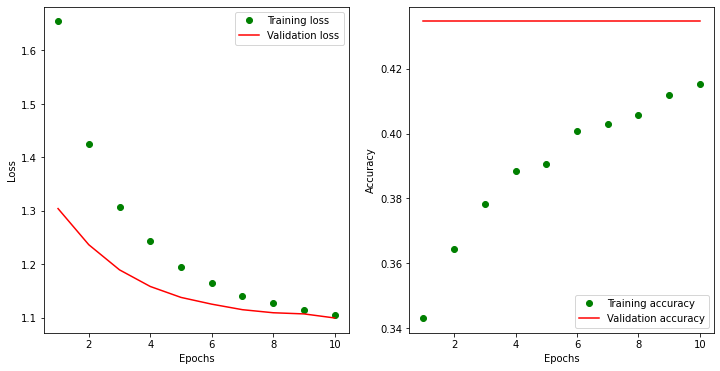

In [117]:
# View training history
plot_training_history(history)

In [118]:
# Add final training, validation loss and accuracy to log
model_log['Model_4']['Metrics'] = {metric: val[-1] for metric, val in history.history.items()}
# View log
model_log['Model_4']

{'Activation': ['relu'],
 'BatchNorm': True,
 'Batch_size': 512,
 'Dropout': 0.375,
 'Epochs': 50,
 'Layers': 2,
 'Learning_rate': 0.001,
 'Metrics': {'accuracy': 0.41528746485710144,
  'loss': 1.1059796810150146,
  'val_accuracy': 0.4345908761024475,
  'val_loss': 1.0997562408447266},
 'Optimiser': 'Adam',
 'Units': [12, 6],
 'l2': 0.01}

In [119]:
# View summary of model architecture with layers and
# number of trainable parameters
model.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 12)                7896      
_________________________________________________________________
batch_normalization_84 (Batc (None, 12)                48        
_________________________________________________________________
dropout_105 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 6)                 78        
_________________________________________________________________
batch_normalization_85 (Batc (None, 6)                 24        
_________________________________________________________________
dropout_106 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_180 (Dense)            (None, 3)               

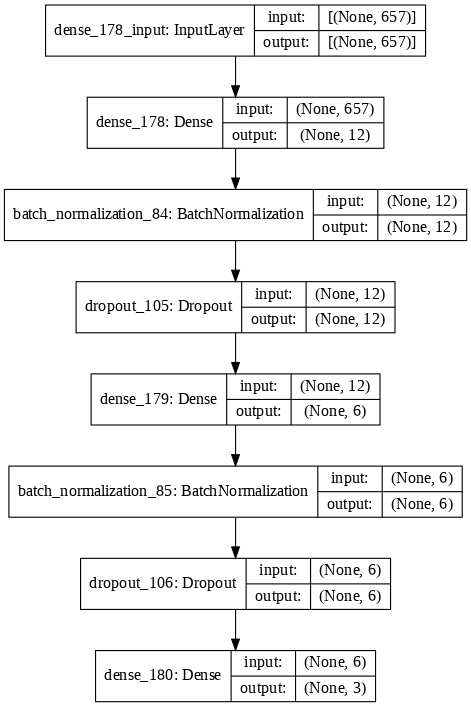

In [126]:
# View diagram of model architecture with layers and shapes of inputs/outputs
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, dpi=80)

#### v. PCA features
We have built a model that performs better than our naive baseline using TF-IDF word vectors and other features, and are quite satisfied with its current state. We will now experiment using the PCA transformed word vectors, where PCA was applied in Q3 using 391 principal components to capture 85% of variance. Compared to the TF-IDF word vectors, the dimension of our features has reduced from 657 to 458. We will see if there is any improvement in our neural network with the reduced dimension of features being used.

In [130]:
# load prepared training features from last save
import pickle
train_prep = pickle.load(open('train_prep_PC_210921.pkl', 'rb'))
print(train_prep.shape)

(40818, 458)


In [132]:
# Hold out 10% of training data for validation
val_ind = round(train_prep.shape[0] * 0.9)

print('Number of training instances:', train_prep.shape[0])
X_train = train_prep[:val_ind]
X_val = train_prep[val_ind:]

# Check split - looks good!
print('Train/val split:')
print(X_train.shape[0])
print(X_val.shape[0])
print('{:.4%}'.format(X_train.shape[0] / train_prep.shape[0]))
print('{:.4%}'.format(X_val.shape[0] / train_prep.shape[0]))

Number of training instances: 40818
Train/val split:
36736
4082
89.9995%
10.0005%
Check labels split:
36736
4082


In [198]:
# Log the architecture settings for updated model
model_log['Model_5'] = {'Optimiser': 'Adam',
                        'Batch_size': 512,
                        'Learning_rate': 0.001, # default for Adam in Keras
                        'Epochs': 50,
                        'Layers': 2,
                        'Units': [12, 6],
                        'Activation': ['relu'],
                        'l2': 0.01,
                        'Dropout': 0.375,
                        'BatchNorm': True,
                        'Features': 'PCA'}

In [197]:
### Fit the selected model using PCA features instead
# Set seed for reproducibility
seed(12)
set_seed(34)

# Initiate neural network
model = models.Sequential()
# Create first layer with 12 units
model.add(layers.Dense(12, activation = 'relu', input_shape = (X_train.shape[1],),
                      kernel_regularizer=l2(0.01))) 
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.375))
# Create 2nd layer with 6 units
model.add(layers.Dense(6, activation = 'relu', kernel_regularizer=l2(0.01))) 
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.375))
# Output layer
model.add(layers.Dense(3, activation = 'softmax'))

# Use Adam optimiser and loss for multiclass classification
model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Train model with same epochs and batch size as before
history = model.fit(X_train, one_hot_y_train,
                    validation_data = (X_val, one_hot_y_val),
                    epochs = 10, # found from early stopping
                    batch_size = 512,
                    callbacks = [earlystop]
                  )

ValueError: ignored

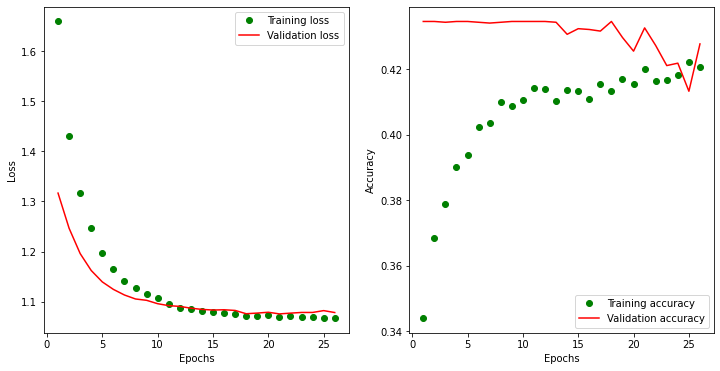

In [134]:
# View training history
plot_training_history(history)

In [ ]:
# Add final training, validation loss and accuracy to log
model_log['Model_5']['Metrics'] = {metric: val[-1] for metric, val in history.history.items()}
# View log
model_log['Model_5']

It looks like the model architecture used for TF-IDF word vectors also works quite well for the PCA transformed word vectors. The performance is also relatively in line with the model using TF-IDF word vectors, but with a marginally higher training and validation loss. The training and validation accuracies are very similar as well.

We will assess models using the two feature sets more rigorously by using cross-validation. As there may be sampling bias in the chosen validation set, we will use 5-fold cross validation that splits the training/validation sets into 5 partitions, and iteratively evaluates on each partition while training on the remaining 4 partitions.

In [148]:
train_prep_TF = pickle.load(open('train_prep_TF_210921.pkl', 'rb'))
train_prep_PC = pickle.load(open('train_prep_PC_210921.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
train_labels = to_categorical(train_labels)

In [174]:
# Create function to build model at each iteration
def build_model():
  # Initiate neural network
  model = models.Sequential()
  # Create first layer with 12 units
  model.add(layers.Dense(12, activation = 'relu', kernel_regularizer=l2(0.01))) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.375))
  # Create 2nd layer with 6 units
  model.add(layers.Dense(6, activation = 'relu', kernel_regularizer=l2(0.01))) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.375))
  # Output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  # Use Adam optimiser and loss for multiclass classification
  model.compile(optimizer='Adam',
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
  return model

In [185]:
# Create function to get accuracy model predictions
def multiclass_acc(model, X_val, y_val):
  # get model predictions as probability scores for each class
  y_pred = model.predict(X_val) 
  # store as dataframe
  y_df = pd.DataFrame(y_pred)
  # get prediction as class with max prob score
  y_df['pred'] = y_pred.argmax(axis=1)
  # add true values
  y_df['true'] = y_val.argmax(axis=1)
  # return accuracy of predictions
  return sum(y_df['pred'] == y_df['true']) / len(y_df)

In [188]:
# Create function for K-fold CV
def kfold_CV(train_data, train_labels, k=5):
  # Specify size of folds based on training data
  fold_size = train_data.shape[0] // k
  val_acc = []
  print('Total training set dim:', train_data.shape)

  for i in range(k):
    print('Fitting fold #{}'.format(i))
    # Partition fold for validation
    X_val = train_data[fold_size*i : fold_size*(i+1)]
    y_val = train_labels[fold_size*i : fold_size*(i+1)]
    print('Validation feature dim:', X_val.shape)
    print('Validation labels dim:', y_val.shape)
    
    # Concatenate remaining folds for training
    X_train = np.concatenate(
        [train_data[:i*fold_size].todense(),
         train_data[(i+1)*fold_size:].todense()]
    )
    print('Training feature dim:', X_train.shape)
    y_train = np.concatenate(
        [train_labels[:i*fold_size],
         train_labels[(i+1)*fold_size:]]
    )
    print('Training labels dim:', y_train.shape)
    
    # Get model from defined architecture
    model = build_model()
    # Fit on training and validation folds
    model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              verbose = 0,
              epochs = 50,
              batch_size = 512,
              callbacks = [earlystop])
    # Store validation accuracy for fold
    val_acc.append(multiclass_acc(model, X_val, y_val))
    print('Fold #{} has validation accuracy of {:.4%}'.\
          format(i, multiclass_acc(model, X_val, y_val)))
  
  return val_acc

In [192]:
# Set seed for reproducibility
seed(12)
set_seed(34)

# Fit training set using TF-IDF word vectors for 5-fold CV
val_acc_TF = kfold_CV(train_prep_TF, train_labels, k=5)

Total training set dim: (40818, 657)
Fitting fold #0
Validation feature dim: (8163, 657)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 657)
Training labels dim: (32655, 3)
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Fold #0 has validation accuracy of 38.7480%
Fitting fold #1
Validation feature dim: (8163, 657)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 657)
Training labels dim: (32655, 3)
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Fold #1 has validation accuracy of 38.0130%
Fitting fold #2
Validation feature dim: (8163, 657)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 657)
Training labels dim: (32655, 3)
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Fold #2 has validation accuracy of 33.5538%
Fitting fold #3
Validation feature dim: (8163, 657)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 657)
Tra

In [193]:
# Set seed for reproducibility
seed(12)
set_seed(34)

# Fit training set using PCA transformed word vectors for 5-fold CV
val_acc_PC = kfold_CV(train_prep_PC, train_labels, k=5)

Total training set dim: (40818, 458)
Fitting fold #0
Validation feature dim: (8163, 458)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 458)
Training labels dim: (32655, 3)
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Fold #0 has validation accuracy of 38.3070%
Fitting fold #1
Validation feature dim: (8163, 458)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 458)
Training labels dim: (32655, 3)
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Fold #1 has validation accuracy of 37.6700%
Fitting fold #2
Validation feature dim: (8163, 458)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 458)
Training labels dim: (32655, 3)
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Fold #2 has validation accuracy of 34.5829%
Fitting fold #3
Validation feature dim: (8163, 458)
Validation labels dim: (8163, 3)
Training feature dim: (32655, 458)
Tra

In [195]:
# Compare validation performance across 5 folds for the two feature sets
print('Validation accuracy of TF-IDF features across 5 folds:', val_acc_TF)
print('Average: {:.4%} Std Dev: {:.4}'.format(np.mean(val_acc_TF), np.std(val_acc_TF)))
print('Validation accuracy of PCA features across 5 folds:', val_acc_PC)
print('Average: {:.4%} Std Dev: {:.4}'.format(np.mean(val_acc_PC), np.std(val_acc_PC)))

Validation accuracy of TF-IDF features across 5 folds: [0.38748009310302584, 0.38012985422026213, 0.33553840499816245, 0.39875045938993015, 0.41614602474580425]
Average: 38.3609% Std Dev: 0.02693
Validation accuracy of PCA features across 5 folds: [0.3830699497733676, 0.3766997427416391, 0.3458287394340316, 0.3789048144064682, 0.4119808893789048]
Average: 37.9297% Std Dev: 0.02102


The TF-IDF features have performed slightly better across the 5 folds compared to the PCA transformed features. This could be due to the additional 15% variance that is retained in using all the TF-IDF features.

In [196]:
# View log of model iterations performed til now
pd.DataFrame(model_log)

,Model_0,Model_1,Model_2,Model_3,Model_4
Optimiser,SGD,Adam,Adam,Adam,Adam
Batch_size,36736,512,512,512,512
Learning_rate,0.01,0.001,0.001,0.001,0.001
Epochs,50,50,50,50,50
Layers,1,1,1,1,2
Units,[8],[8],[8],[8],"[12, 6]"
Activation,[relu],[relu],[relu],[relu],[relu]
Regularisation,None,None,NaN,NaN,NaN
Metrics,"{'loss': 1.1019513607025146, 'accuracy': 0.336...","{'loss': 0.9853881597518921, 'accuracy': 0.508...","{'loss': 1.0683637857437134, 'accuracy': 0.422...","{'loss': 1.0471855401992798, 'accuracy': 0.453...","{'loss': 1.1059796810150146, 'accuracy': 0.415..."
l2,NaN,NaN,0.01,0.01,0.01


In [209]:
# Compare metrics
pd.DataFrame(model_log).transpose().Metrics.apply(pd.Series)

,loss,accuracy,val_loss,val_accuracy
Model_0,1.101951,0.336672,1.104590,0.299608
Model_1,0.985388,0.508303,1.120125,0.365017
Model_2,1.068364,0.422011,1.077609,0.422587
Model_3,1.047186,0.453207,1.086943,0.430671
Model_4,1.105980,0.415287,1.099756,0.434591


The performance of our model has steadily improved over the iterations. Although, the addition of the 2nd layer in Model_4 is arguably an improvement over the single layer in Model_3. This comparison can warrant further testing with cross-validation, and also separate hyperparameter tuning for both architectures. As both models produce decent results, we will continue with the simpler model that has a single hidden layer and aim to improve its performance through hyperparameter tuning.

#### vi. Hyperparameter tuning

In [225]:
# Create function to build model at each iteration
from tensorflow.keras.optimizers import Adam

def train_model(param):
  # Extract parameters
  learning_rate = param[0]
  batch_size = param[1]
  l2 = param[2]
  dropout = param[3]
  units = param[4]
  activation = param[5]

  # Initiate neural network
  model = models.Sequential()
  # Create first layer with selected parameters
  model.add(layers.Dense(units, activation = activation, kernel_regularizer=l2(l2))) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(dropout))
  # Output layer
  model.add(layers.Dense(3, activation = 'softmax'))

  # Use Adam optimiser and loss for multiclass classification
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])
  
  # Fit on training and validation folds
  model.fit(X_train, y_train,
            validation_data = (X_val, y_val),
            verbose = 0,
            epochs = 50,
            batch_size = batch_size,
            callbacks = [earlystop])
  loss, _ = model.evaluate(X_val, y_val)
  return {'loss': loss, 'status': STATUS_OK, 
          'val_acc': multiclass_acc(model, X_val, y_val)}

In [275]:
4*6*4*5*3 // 5

288

In [245]:
params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
          'batch_size': [16, 32, 64, 128, 256, 512],
          'l2': [0.0001, 0.001, 0.01, 0.1],
          'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
          'units': [6, 8, 10],
          'activation': ['relu', 'tanh', 'sigmoid', 'elu']}

In [284]:
2*3*2*3

36

In [286]:
params = {'learning_rate': [0.001, 0.01],
          'batch_size': [32, 128, 512],
          'l2': [0.01, 0.1],
          'dropout': [0.3],
          'units': [6, 8, 10]}

param_grid = np.array(np.meshgrid(params['learning_rate'], 
                                  params['batch_size'],
                                  params['l2'],
                                  params['dropout'],
                                  params['units'])).reshape(5, 36)
print(param_grid.shape)

for i in range(param_grid.shape[1]):
  train_model(param_grid[:, i])

(5, 36)


In [292]:
param_grid[:, 0]

32.0

In [288]:
pd.DataFrame(param_grid)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01
1,32.000,32.000,32.000,32.000,32.000,32.000,32.00,32.00,32.00,32.00,32.00,32.00,128.000,128.000,128.000,128.000,128.000,128.000,128.00,128.00,128.00,128.00,128.00,128.00,512.000,512.000,512.000,512.000,512.000,512.000,512.00,512.00,512.00,512.00,512.00,512.00
2,0.010,0.010,0.010,0.100,0.100,0.100,0.01,0.01,0.01,0.10,0.10,0.10,0.010,0.010,0.010,0.100,0.100,0.100,0.01,0.01,0.01,0.10,0.10,0.10,0.010,0.010,0.010,0.100,0.100,0.100,0.01,0.01,0.01,0.10,0.10,0.10
3,0.300,0.300,0.300,0.300,0.300,0.300,0.30,0.30,0.30,0.30,0.30,0.30,0.300,0.300,0.300,0.300,0.300,0.300,0.30,0.30,0.30,0.30,0.30,0.30,0.300,0.300,0.300,0.300,0.300,0.300,0.30,0.30,0.30,0.30,0.30,0.30
4,6.000,8.000,10.000,6.000,8.000,10.000,6.00,8.00,10.00,6.00,8.00,10.00,6.000,8.000,10.000,6.000,8.000,10.000,6.00,8.00,10.00,6.00,8.00,10.00,6.000,8.000,10.000,6.000,8.000,10.000,6.00,8.00,10.00,6.00,8.00,10.00


In [269]:
np.array(np.meshgrid(params['learning_rate'], params['batch_size'])).reshape(2, 24))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


array([[list([0.0001, 0.001, 0.01, 0.1]),
        list([16, 32, 64, 128, 256, 512]),
        list([0.0001, 0.001, 0.01, 0.1]),
        list([0.1, 0.2, 0.3, 0.4, 0.5]), list([6, 8, 10])]], dtype=object)

Use the full training set to train the neural network before evaluating on the test set.

## c. Tree based model

Tree-based models offer powerful out-of-the-box machine learning algorithms, such as Random Forest and Gradient Boosting Machine. These algorithms on based on splitting the feature space into partitions where the value of the target variable is as homogoneous as possible.

We will first explore the basic building block - a single decision tree.

In [ ]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise 

In [ ]:
# Create some functions for performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_train, y_train_pred):
  cm = confusion_matrix(y_train, y_train_pred)
  sns.heatmap(cm/np.sum(cm), cmap='crest', annot=True, fmt='.2%',
              xticklabels=['Decrease', 'Neutral', 'Increase'],
              yticklabels=['Decrease', 'Neutral', 'Increase'])  
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

### Decision tree

In [ ]:
# Fit our first model with default hyperparameters - straight 'out-of-the-box'
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     16109
         1.0       0.99      0.98      0.99      8203
         2.0       0.99      0.99      0.99     12424

    accuracy                           0.99     36736
   macro avg       0.99      0.99      0.99     36736
weighted avg       0.99      0.99      0.99     36736



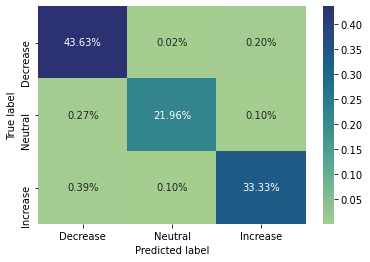

In [ ]:
# Look at training performance
from sklearn.metrics import classification_report

# Get training predictions
y_train_pred = dec_tree.predict(X_train)

# Visualise confusion matrix
plot_cm(y_train, y_train_pred)

# Produce precision-recall scores for each class
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.47      0.53      0.50      1634
         1.0       0.29      0.26      0.27       800
         2.0       0.48      0.44      0.46      1648

    accuracy                           0.44      4082
   macro avg       0.41      0.41      0.41      4082
weighted avg       0.44      0.44      0.44      4082



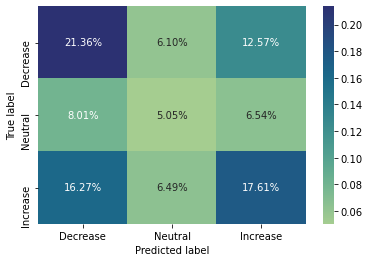

In [ ]:
## The training performance looks too good to be true - most likely it has overfitted.
# Let's look at how our decision tree performs on our validation set.
# Get validation predictions
y_val_pred = dec_tree.predict(X_val)

# Visualise confusion matrix
plot_cm(y_val, y_val_pred)

# Produce precision-recall scores for each class
print(classification_report(y_val, y_val_pred))

In [ ]:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The model has severely overfitted on the training set, with a validation accuracy of 0.44 and a training accuracy of 0.99. The default hyperparameters have a few clues about why the model has overfit. For example, there is no limit to the depth of the tree so the model can continue to split until it has virtually memorised the data. We will experiment with different combinations of hyperparameters using a grid search of selected hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [3, 5, 7, 10],
          'min_samples_split': [10, 50, 100]}

grid = GridSearchCV(dec_tree, params, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                        

In [ ]:
# Best set of hyperparameters from our grid is max_depth of 3 and
# min_samples_split of 10
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Look at training results for all combinations - max_depth of 3 looks like the
# main factor
cv_res = grid.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
  print(mean_score, params)

0.42026845007042224 {'max_depth': 3, 'min_samples_split': 10}
0.42026845007042224 {'max_depth': 3, 'min_samples_split': 50}
0.42026845007042224 {'max_depth': 3, 'min_samples_split': 100}
0.37728754970107303 {'max_depth': 5, 'min_samples_split': 10}
0.37755976965479554 {'max_depth': 5, 'min_samples_split': 50}
0.37750532566405104 {'max_depth': 5, 'min_samples_split': 100}
0.35983825066745384 {'max_depth': 7, 'min_samples_split': 10}
0.3600015826396874 {'max_depth': 7, 'min_samples_split': 50}
0.3599199166535706 {'max_depth': 7, 'min_samples_split': 100}
0.3666437495105191 {'max_depth': 10, 'min_samples_split': 10}
0.36707930143647527 {'max_depth': 10, 'min_samples_split': 50}
0.36694319145961396 {'max_depth': 10, 'min_samples_split': 100}


              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57      1634
         1.0       0.00      0.00      0.00       800
         2.0       0.00      0.00      0.00      1648

    accuracy                           0.40      4082
   macro avg       0.13      0.33      0.19      4082
weighted avg       0.16      0.40      0.23      4082



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


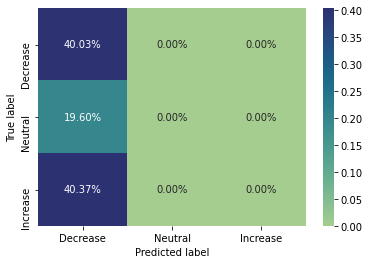

In [ ]:
# Check the performance of tuned model
y_val_pred = grid.predict(X_val)

# Visualise confusion matrix
plot_cm(y_val, y_val_pred)

# Produce precision-recall scores for each class
print(classification_report(y_val, y_val_pred))

The tuned model has predicted all cases as a 'Decrease', which may be due to the relatively small depth of 3. We can spend more time tuning the hyperparameters, but first, we will look into further models.

### Random forest

Random forest builds upon the decision tree by fitting many decision trees and using the ensemble to produce more accurate predictions. Each tree is also fitted on a random subset of features. This has been shown to produce more robust predictions as it reduces the correlation between the trees, and overfitting.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     16109
         1.0       1.00      0.98      0.99      8203
         2.0       0.99      0.99      0.99     12424

    accuracy                           0.99     36736
   macro avg       0.99      0.99      0.99     36736
weighted avg       0.99      0.99      0.99     36736



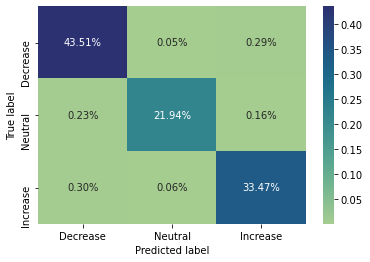

In [ ]:
# Get training predictions
y_train_pred = rf.predict(X_train)

# Visualise confusion matrix
plot_cm(y_train, y_train_pred)

# Produce precision-recall scores for each class
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.44      0.77      0.56      1634
         1.0       0.64      0.15      0.24       800
         2.0       0.51      0.31      0.39      1648

    accuracy                           0.46      4082
   macro avg       0.53      0.41      0.40      4082
weighted avg       0.51      0.46      0.43      4082



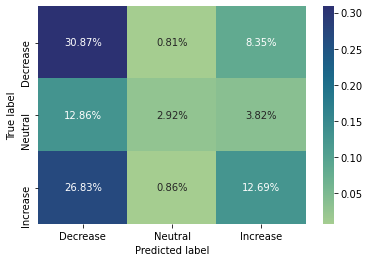

In [ ]:
## The random forest most likely has also overfitted.
# Let's look at the validation performance.
# Get validation predictions
y_val_pred = rf.predict(X_val)

# Visualise confusion matrix
plot_cm(y_val, y_val_pred)

# Produce precision-recall scores for each class
print(classification_report(y_val, y_val_pred))

The random forest has slightly better performance than our decision tree, with a validation accuracy of 0.46 compared to 0.44. However, the random forest has lower F1-scores for 'Neutral' and 'Increase' predictions, while it has a much higher recall for 'Decreases' giving it a larger F1-score for this one class.

We will also attempt tuning its hyperparameters to prevent overfitting.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [120, 160, 200], 'max_features': [6, 7, 8]}

# 20 min..
# grid = GridSearchCV(rf, params, n_jobs=-1 , return_train_score=True)
# grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
# Best set of hyperparameters from our grid is ?
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Look at training results for all combinations - max_depth of 3 looks like the
# main factor
cv_res = grid.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
  print(mean_score, params)

0.36917486901544916 {'max_features': 6, 'n_estimators': 120}
0.37026373771629684 {'max_features': 6, 'n_estimators': 160}
0.3677865250233784 {'max_features': 6, 'n_estimators': 200}
0.3669699170277434 {'max_features': 7, 'n_estimators': 120}
0.36729652540199675 {'max_features': 7, 'n_estimators': 160}
0.36936540445965044 {'max_features': 7, 'n_estimators': 200}
0.36827655798688824 {'max_features': 8, 'n_estimators': 120}
0.36754160115864637 {'max_features': 8, 'n_estimators': 160}
0.3691748541967256 {'max_features': 8, 'n_estimators': 200}


              precision    recall  f1-score   support

         0.0       0.44      0.76      0.55      1634
         1.0       0.63      0.16      0.26       800
         2.0       0.51      0.32      0.39      1648

    accuracy                           0.46      4082
   macro avg       0.52      0.41      0.40      4082
weighted avg       0.50      0.46      0.43      4082



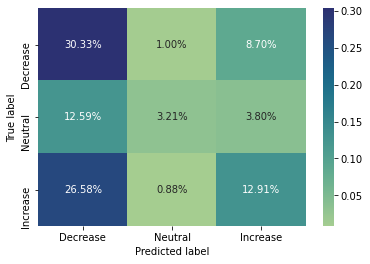

In [ ]:
# Check the performance of tuned model
y_val_pred = grid.predict(X_val)

# Visualise confusion matrix
plot_cm(y_val, y_val_pred)

# Produce precision-recall scores for each class
print(classification_report(y_val, y_val_pred))

The tuned random forest is a significant improvement to both our initial random forest with default hyperparameters and our tuned decision tree. It has higher accuracy as 0.46 and greater amount of correctly predicted 'Increases'.

We will fit one more tree-based model, the gradient boosting machine, before evaluating the performance of our fitted models on the test set.

### GBM

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(data=X_train, label=y_train)

In [ ]:
param = {'num_leaves': 31, 'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3}

num_round = 10
bst = lgb.train(param, train_data, num_round)

              precision    recall  f1-score   support

         0.0       0.45      0.98      0.62     16109
         1.0       0.69      0.00      0.00      8203
         2.0       0.61      0.10      0.17     12424

    accuracy                           0.46     36736
   macro avg       0.59      0.36      0.26     36736
weighted avg       0.56      0.46      0.33     36736



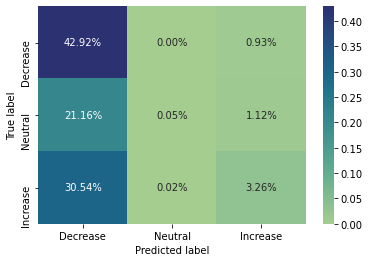

In [ ]:
# Check training performance
y_train_pred = bst.predict(X_train).argmax(axis=1)

# Visualise confusion matrix
plot_cm(y_train, y_train_pred)

# Produce precision-recall scores for each class
print(classification_report(y_train, y_train_pred))

In [ ]:
num_leaves = [30, 60, 90]
min_data_in_leaf = [100, 500, 1000]

In [ ]:
help(lgb.train)

Help on function train in module lightgbm.engine:

train(params, train_set, num_boost_round=100, valid_sets=None, valid_names=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, evals_result=None, verbose_eval=True, learning_rates=None, keep_training_booster=False, callbacks=None)
    Perform the training with given parameters.
    
    Parameters
    ----------
    params : dict
        Parameters for training.
    train_set : Dataset
        Data to be trained on.
    num_boost_round : int, optional (default=100)
        Number of boosting iterations.
    valid_sets : list of Datasets or None, optional (default=None)
        List of data to be evaluated on during training.
    valid_names : list of strings or None, optional (default=None)
        Names of ``valid_sets``.
    fobj : callable or None, optional (default=None)
        Customized objective function.
    feval : callable or None, optional (default=None)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
results = {}
results['num_leaves'] = []
results['min_data_in_leaf'] = []
results['train_accuracy'] = []
results['val_accuracy'] = []

for leaves in num_leaves:
  for min_data in min_data_in_leaf:
    param = {'num_leaves': leaves, 'min_data_in_leaf': min_data,
             'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3}    
    gbm = lgb.train(param, train_data, num_boost_round=20)
    y_train_pred = gbm.predict(X_train).argmax(axis=1)
    y_val_pred = gbm.predict(X_val).argmax(axis=1)
    
    results['num_leaves'].append(leaves)
    results['min_data_in_leaf'].append(min_data)
    results['train_accuracy'].append(accuracy_score(y_train, y_train_pred))
    results['val_accuracy'].append(accuracy_score(y_val, y_val_pred))

    print('Leaves: {}, Min_data_in_leaf: {}'.format(leaves, min_data))
    # Produce precision-recall scores for each class
    print(classification_report(y_train, y_train_pred))
    print(classification_report(y_val, y_val_pred))
    print('='*40)

Leaves: 30, Min_data_in_leaf: 100
              precision    recall  f1-score   support

         0.0       0.46      0.94      0.62     16109
         1.0       0.66      0.00      0.01      8203
         2.0       0.57      0.18      0.27     12424

    accuracy                           0.47     36736
   macro avg       0.56      0.37      0.30     36736
weighted avg       0.54      0.47      0.36     36736

              precision    recall  f1-score   support

         0.0       0.40      0.97      0.57      1634
         1.0       0.00      0.00      0.00       800
         2.0       0.49      0.04      0.07      1648

    accuracy                           0.40      4082
   macro avg       0.30      0.34      0.21      4082
weighted avg       0.36      0.40      0.26      4082

Leaves: 30, Min_data_in_leaf: 500
              precision    recall  f1-score   support

         0.0       0.45      0.94      0.61     16109
         1.0       1.00      0.00      0.00      8203
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Leaves: 30, Min_data_in_leaf: 1000
              precision    recall  f1-score   support

         0.0       0.45      0.94      0.60     16109
         1.0       0.00      0.00      0.00      8203
         2.0       0.47      0.11      0.18     12424

    accuracy                           0.45     36736
   macro avg       0.30      0.35      0.26     36736
weighted avg       0.35      0.45      0.32     36736

              precision    recall  f1-score   support

         0.0       0.39      0.82      0.53      1634
         1.0       0.00      0.00      0.00       800
         2.0       0.39      0.16      0.22      1648

    accuracy                           0.39      4082
   macro avg       0.26      0.32      0.25      4082
weighted avg       0.31      0.39      0.30      4082

Leaves: 60, Min_data_in_leaf: 100
              precision    recall  f1-score   support

         0.0       0.47      0.91      0.62     16109
         1.0       0.63      0.01      0.02      8203
      

In [ ]:
pd.DataFrame(results)

,num_leaves,min_data_in_leaf,train_accuracy,val_accuracy
0,30,100,0.472479,0.403969
1,30,500,0.456609,0.404704
2,30,1000,0.446837,0.389515
3,60,100,0.485845,0.419647
4,60,500,0.461182,0.402254
5,60,1000,0.446837,0.389515
6,90,100,0.499292,0.417197
7,90,500,0.461182,0.402254
8,90,1000,0.446837,0.389515


In [ ]:
pd.DataFrame(results)

,num_leaves,min_data_in_leaf,train_accuracy,val_accuracy
0,30,100,0.457617,0.402744
1,30,500,0.451192,0.400294
2,30,1000,0.440767,0.400294
3,60,100,0.465347,0.405194
4,60,500,0.453561,0.403724
5,60,1000,0.440767,0.400294
6,90,100,0.472479,0.408623
7,90,500,0.453561,0.403724
8,90,1000,0.440767,0.400294


Feature importance - model interpretability - SHAP?

In [ ]:
pd.DataFrame({'Features': feat_cols,
              'Feat_Imp': gbm.feature_importance()})

In [ ]:
pip install shap

     |████████████████████████████████| 356 kB 15.8 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=67e9ecf8953e5004a25c547c4e8a8e64c6a293d564cba5ce1217e08c90acc11f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
gbm.feature_importances_[gbm.feature_importances_.argmax()] # name

0.07781895427402095

In [ ]:
gbm.feature_importances_[:52].sum()

0.29348359650131406

In [ ]:
gbm.feature_importances_[52:].sum()

0.7065164034986859

In [ ]:
check = pd.DataFrame({'Pred': y_pred, 'Target': y_train})
check.loc[check.Pred != check.Target]

,Pred,Target
index,,
1136,2.0,1.0
1218,2.0,0.0
1487,2.0,1.0
1651,1.0,2.0
1820,0.0,2.0
...,...,...
113099,0.0,1.0
113103,2.0,1.0
113146,0.0,1.0


In [ ]:
rf.feature_importances_[rf.feature_importances_.argmax()]

0.050888254206570435

## d. Model evaluation

We will now test our selected models on the test data.

3 measures of success:
* Model performance on test set
* Model performance relative to benchmark model (linear regression)
* Back-testing profit/loss if model was actually used to trade stocks

Justifies the measures used given the problem context.

Demonstrates, via comments in the notebook, an excellent understanding of how predictive each model is.

In [ ]:
# Transform test data
pipeline.transform(X_test)

In [ ]:
# Linear regression benchmark model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

lin_reg = LinearRegression()
lin_reg.fit(X_train, one_hot_y_train)
y_pred = lin_reg.predict(X_train)

# Get summary of predictions vs actual values
pred_df = pd.DataFrame(y_pred, columns=[0, 1, 2])
pred_df['Actual'] = y_train.to_list()
pred_df['Pred'] = y_pred.argmax(axis=1)

# Confusion matrix
pd.crosstab(pred_df['Actual'], pred_df['Pred'])
print(classification_report(pred_df['Actual'], pred_df['Pred']))

In [ ]:
# Check feature importance / size of coefficients per class
feat_coef_LR = pd.DataFrame({'Feature': feat_cols, 'LR_Coef0': lin_reg.coef_[0],
                             'LR_Coef1': lin_reg.coef_[1], 'LR_Coef2': lin_reg.coef_[2]})

for col in ['LR_Coef0', 'LR_Coef1', 'LR_Coef2']:
  print('Top features for {}:\n{}\n'.format(col, feat_coef_LR.sort_values(col)[-5:]))

In [ ]:
# Some of these tweets just don't make sense in relation to stock prices...
# Find a way to see if tweets are relevant at all
# Some features look like they have relation just by chance
check = train.loc[train.name=='Emma Vosti', ['tweet_text', 'tweet_post_time', 'target']]

for i in range(len(check)):
  print('Target: {}\nTweet: {}\n'.format(check.iloc[i].target, check.iloc[i].tweet_text))

Target: 1.0
Tweet: RT @KateMcG6: #Russell #MAFSAU https://t.co/Pxc4foqEhV

Target: 1.0
Tweet: RT @whatsuptanny: Staying tuned to see if Russ changes into his North Face for the reception #mafs #MAFSAU

Target: 1.0
Tweet: This groom looks like Daniel Andrews ... #MAFSAU

Target: 1.0
Tweet: Mugatoo has my vote! @allstarmile @RacingInsider  https://t.co/8NxHL19KkY #allstarmile

Target: 0.0
Tweet: RT @McGrathFdn: Two years ago I would have said that blokes don't get breast cancer. I didn't think they did."

@emmavosti from @Channel7 sâ¦

Target: 0.0
Tweet: @tim_michell Thank you! I felt privileged just to sit and listen.

Target: 0.0
Tweet: Anyone throw an annual Boxing Day bbq in Melbourne or regional Vic? Whatâs unique about it?

Target: 2.0
Tweet: RT @leighsales: Is it to do with mystery cases/NSW cases inflated by overseas travellers in quarantine/the kind of cases in those numbers eâ¦

Target: 2.0
Tweet: RT @leighsales: Thereâs something I donât understand - looking at NSW sta